In [1]:
cd ..

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing


In [2]:
# ignore this cell if not using local env vars
# # needs to be done before importing transformers
import os
os.environ['TRANSFORMERS_OFFLINE'] = '1'
os.environ['HF_HOME'] = "/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/downloads"
os.environ['TRANSFORMERS_CACHE'] = "/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/downloads"


In [3]:
%matplotlib inline


%load_ext autoreload
%autoreload 2


import torch
import re
import numpy as np
import sklearn
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import seaborn as sns
import copy

from torch.utils.data import DataLoader
import transformer_lens
import datasets

from load import *

from analysis.load_results import (
    load_probing_experiment_results, 
    make_heuristic_probing_results_df
)

from analysis.plots import *




## Load Results

In [6]:


results_dir = '/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/results'
sizes = ['19m', '125m', '350m', '800m', '1.3b']
all_results = []
for s in sizes:
    results_dict = load_probing_experiment_results(results_dir, 'code_lang_max_test', 'heuristic_sparsity_sweep', f'pythia-{s}')
    rdf = make_heuristic_probing_results_df(results_dict)
    # add model size to index of rdf
    rdf.index = pd.MultiIndex.from_tuples([
        (s, *t) for t in rdf.index.values],
        names=['model_size', 'feature', 'layer', 'k']
    )
    all_results.append(rdf)
rdf = pd.concat(all_results)

In [1]:
rdf.query('k==1 and model_size=="19m"').sort_values('test_pr_auc', ascending=False).head(10)

NameError: name 'rdf' is not defined

In [10]:
interp_neurons = rdf.query('k==1 and model_size=="800m"').sort_values('test_pr_auc', ascending=False).head(10).reset_index()[['feature', 'layer', 'support']].values
interp_neurons = [(f, l, n[0]) for f, l, n in interp_neurons]
interp_neurons

[('Python', 10, 3855),
 ('Go', 1, 884),
 ('Python', 9, 1693),
 ('Go', 6, 3108),
 ('Python', 6, 7172),
 ('PHP', 10, 5633),
 ('Java', 6, 4070),
 ('Go', 9, 1823),
 ('PHP', 9, 7926),
 ('Python', 1, 5423)]

## Plot overall sparsity curves

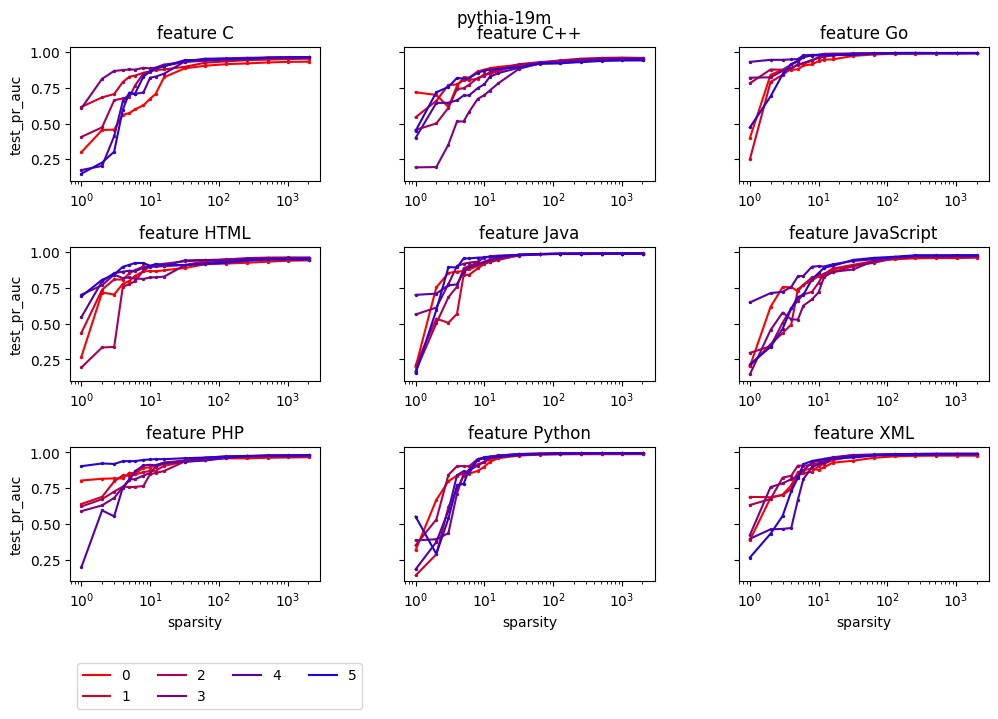

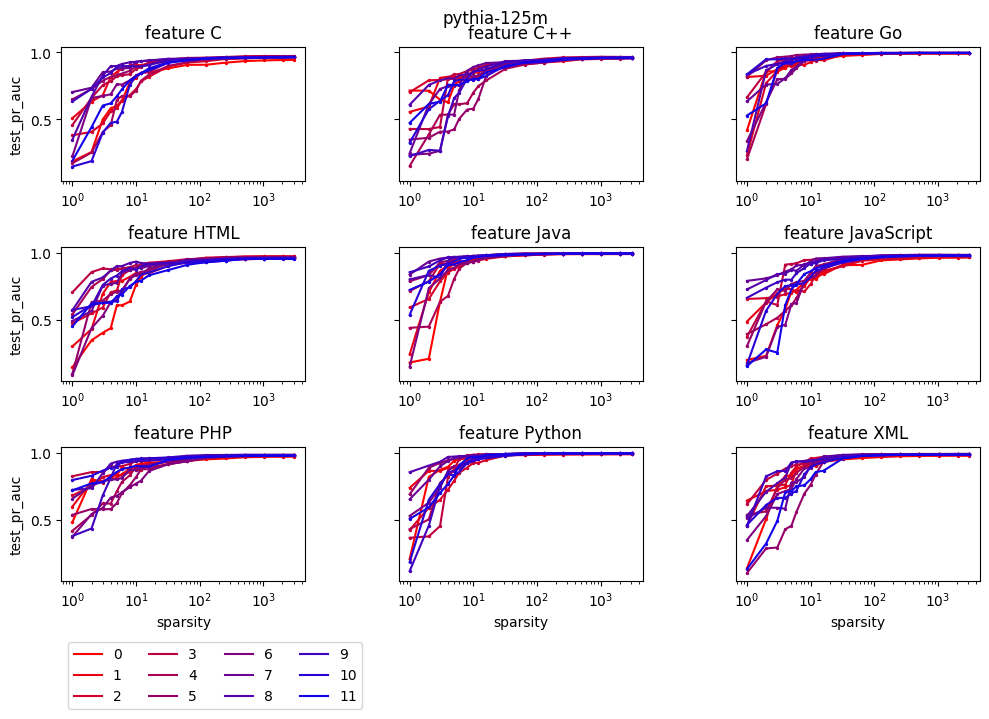

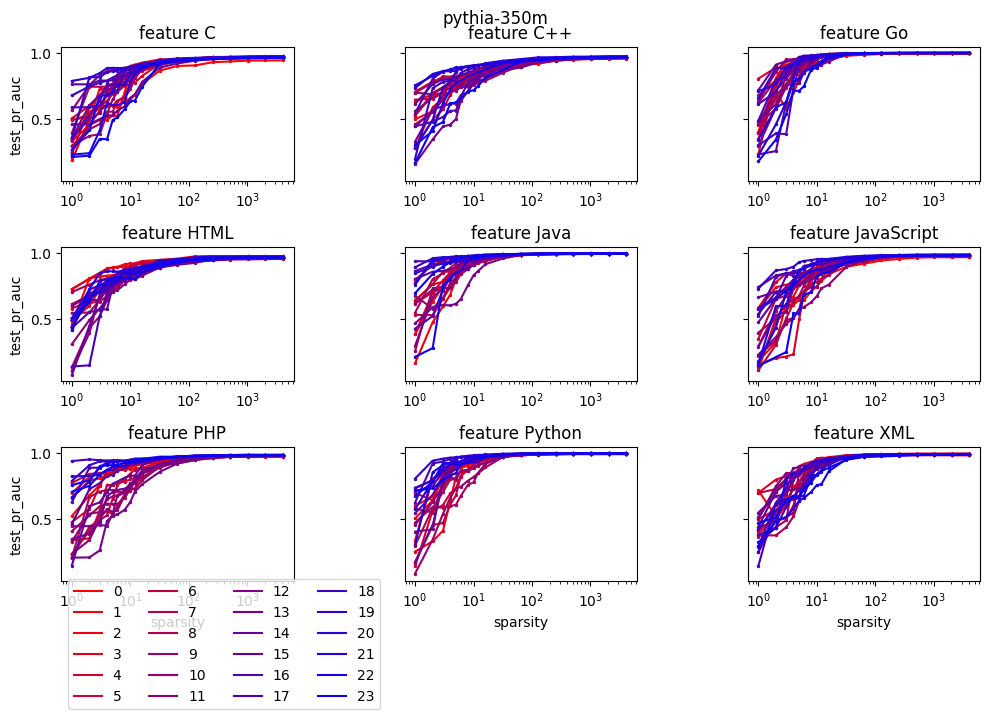

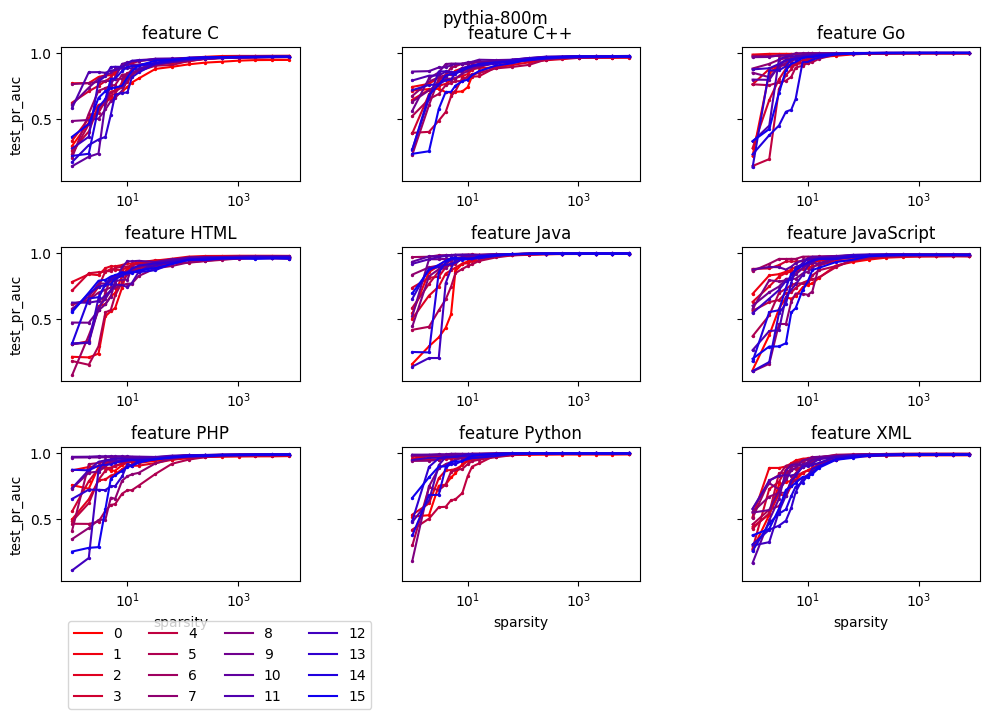

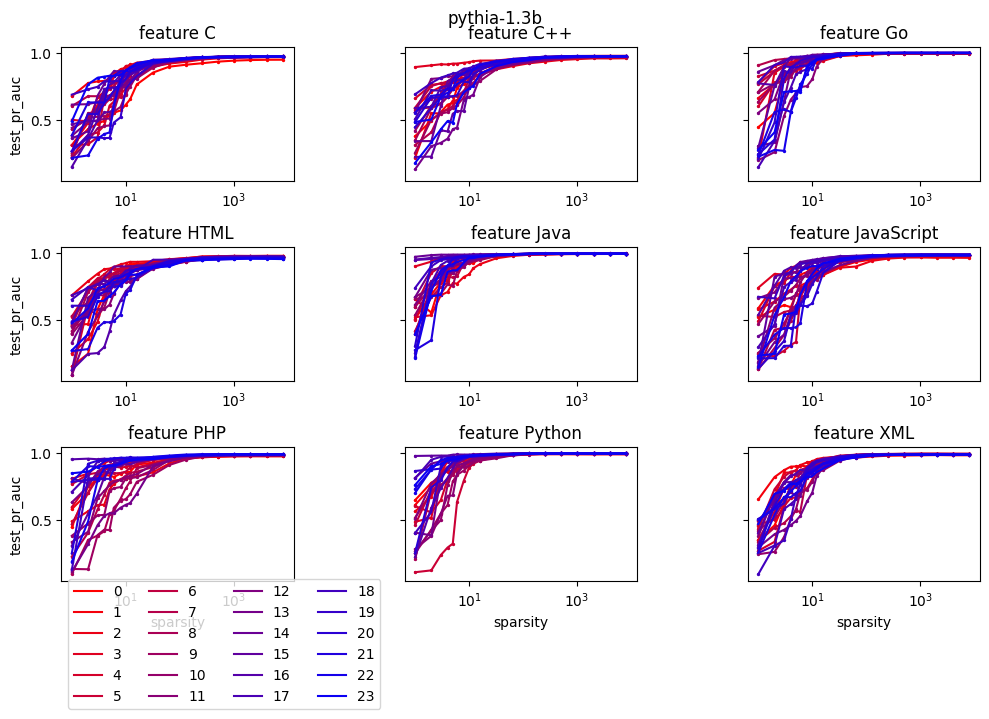

In [11]:
for s in sizes:
    plot_layer_metric_over_sparsity_per_feature(rdf.query(f'model_size=="{s}"').reset_index(level=0, drop=True), metric='test_pr_auc')
    # raise the title of the plot
    plt.suptitle(f'pythia-{s}', y=1.0)


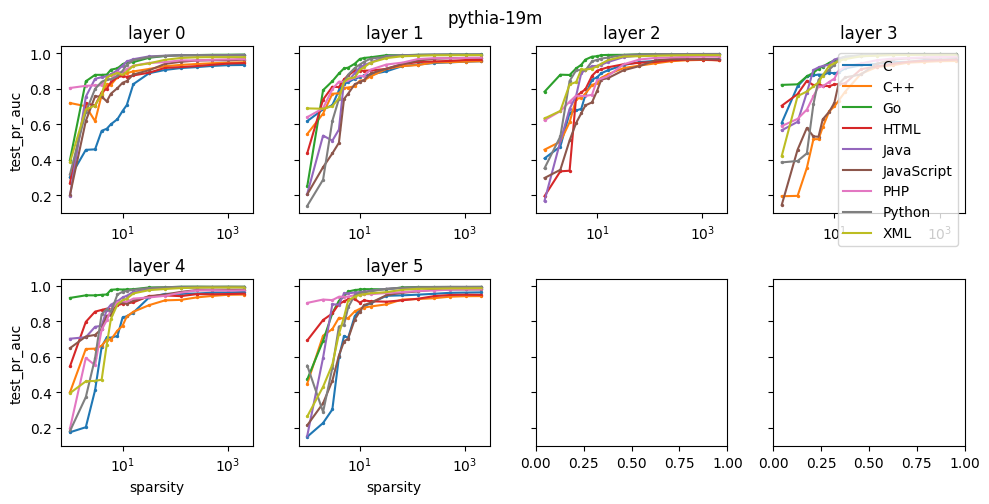

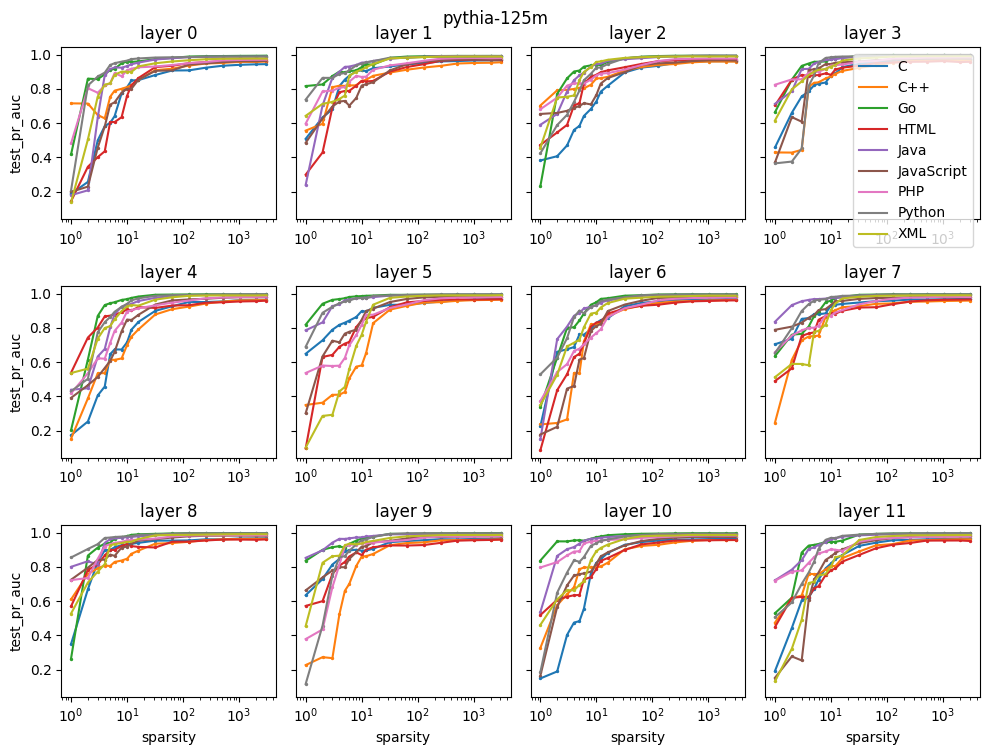

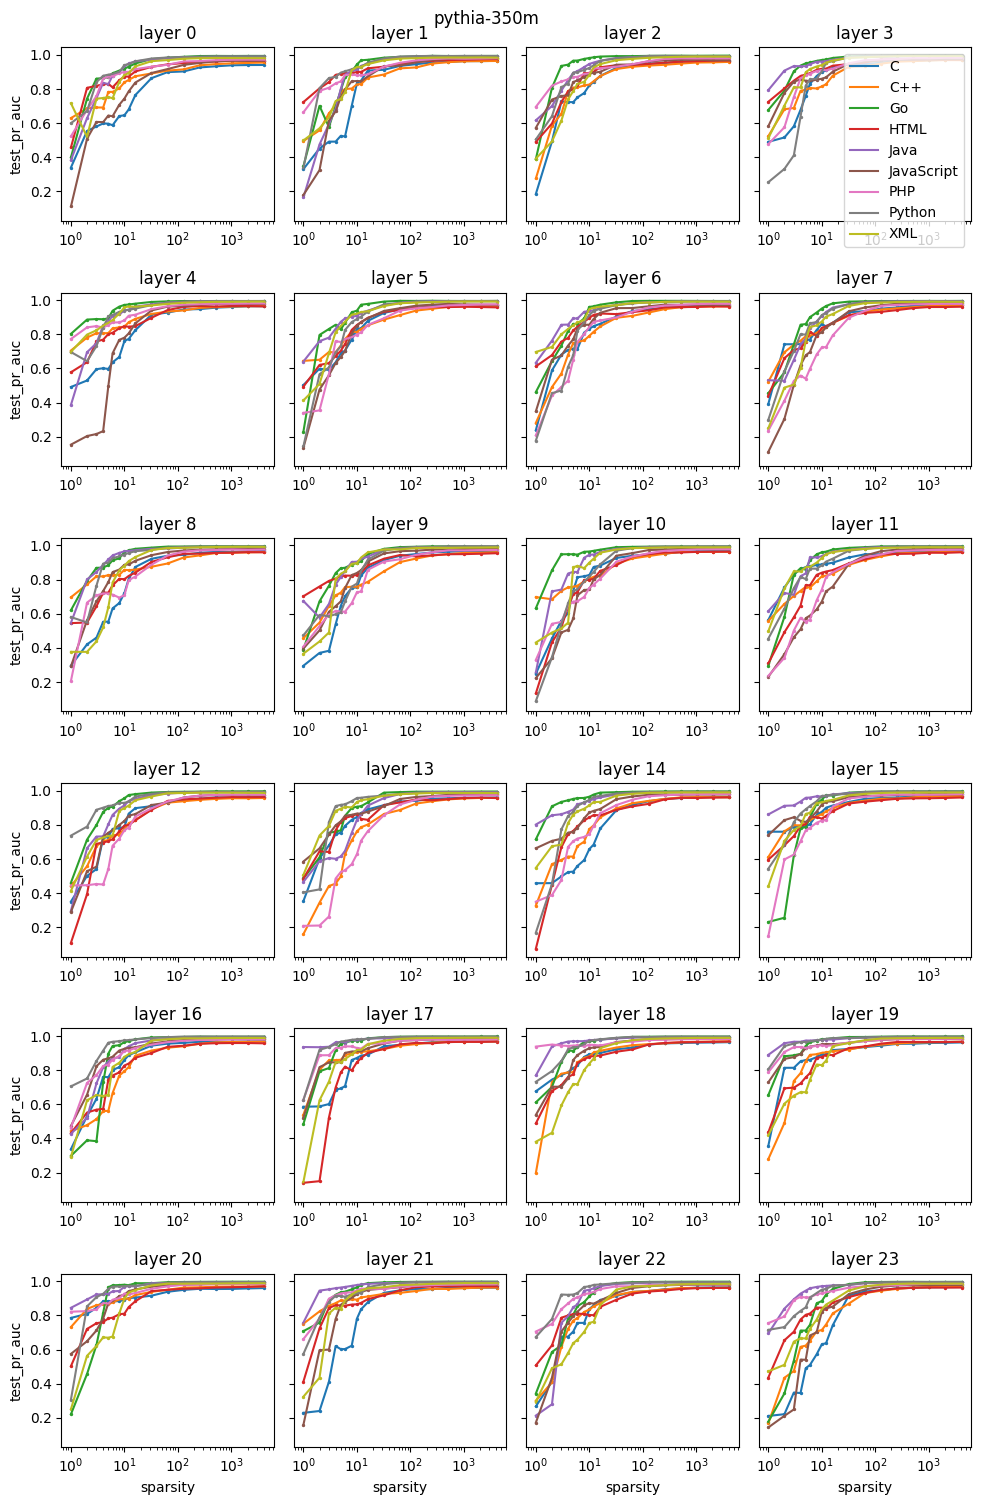

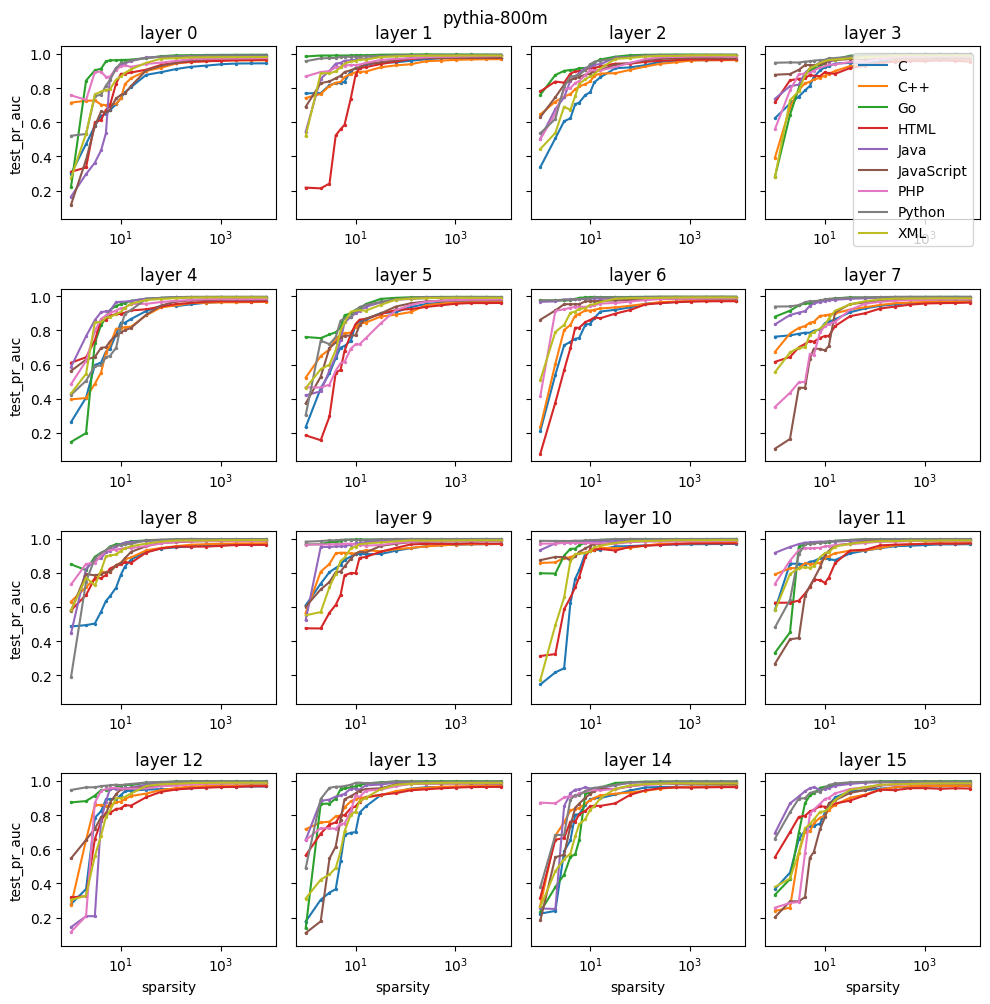

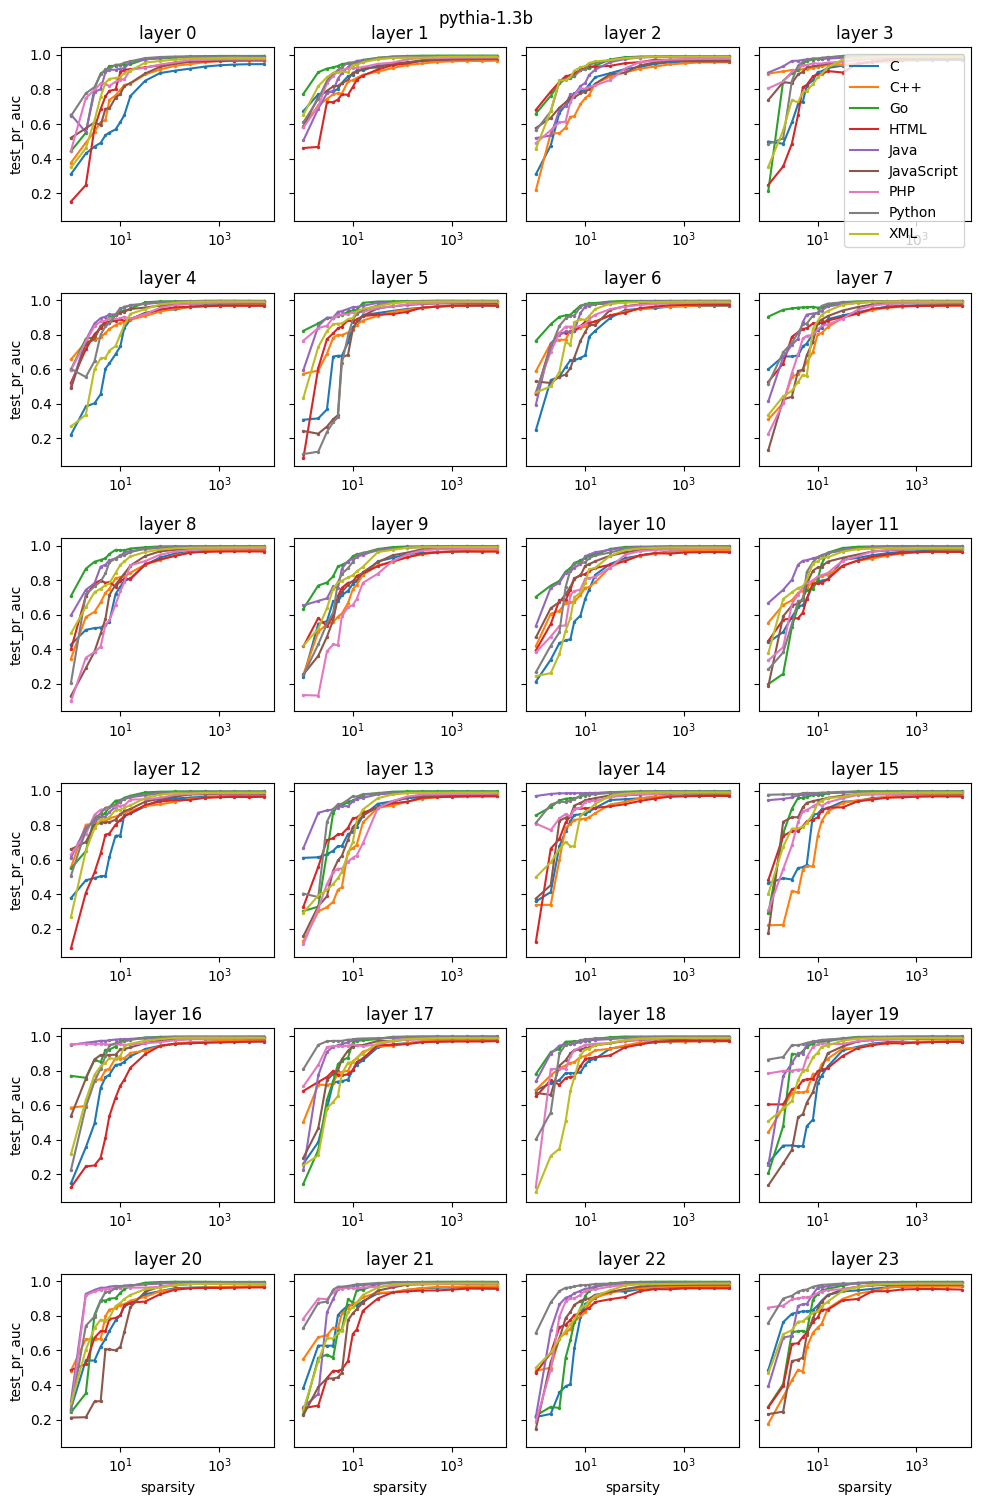

In [12]:
for s in sizes:
    plot_metric_over_sparsity_per_layer(rdf.query(f'model_size=="{s}"').reset_index(level=0, drop=True), 
    metric='test_pr_auc')
    # raise the title of the plot
    plt.suptitle(f'pythia-{s}', y=1.0)

In [53]:
# top = rdf.query('model_size=="19m" and k==1').sort_values('test_pr_auc', ascending=False).head(10)
# interp_neurons = top.reset_index()[['layer', 'support']].values
# interp_neurons = [f'{l},{n[0]}' for l, n in interp_neurons]
# ' '.join(interp_neurons)

'4,295 5,1549 3,1855 0,374 2,363 0,1302 3,338 4,1721 5,1010 1,1466'

## Load activations of specific neurons

In [13]:
from activation_subset_experiment import load_activation_subset
model_name = 'pythia-800m'
dataset_name = 'programming_lang_id.pyth.512.-1'
experiment_name = 'code_monosemantic'

act_subset_dict, metadata = load_activation_subset(model_name, dataset_name, experiment_name)
feature_dataset = load_feature_dataset(dataset_name)
model = load_model('pythia-19m') # only need tokenizer so load smallest model

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(
Using pad_token, but it is not set yet.


Loaded pretrained model pythia-19m into HookedTransformer


In [24]:

def plot_all_neuron_histograms(act_subset_dict, n_cols=5, logx=False):
    n = len(act_subset_dict)
    n_rows = math.ceil(n / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
    for ix, (layer, neuron) in enumerate(act_subset_dict.keys()):
        activations = act_subset_dict[(layer, neuron)]
        ax = axs[ix//n_cols, ix%n_cols]
        ax.hist(activations[:, 1:].numpy().flatten(), bins=100)
        ax.set_title(f'Layer {layer}, Neuron {neuron}')
        if logx:
            ax.set_yscale('log')
    plt.tight_layout()


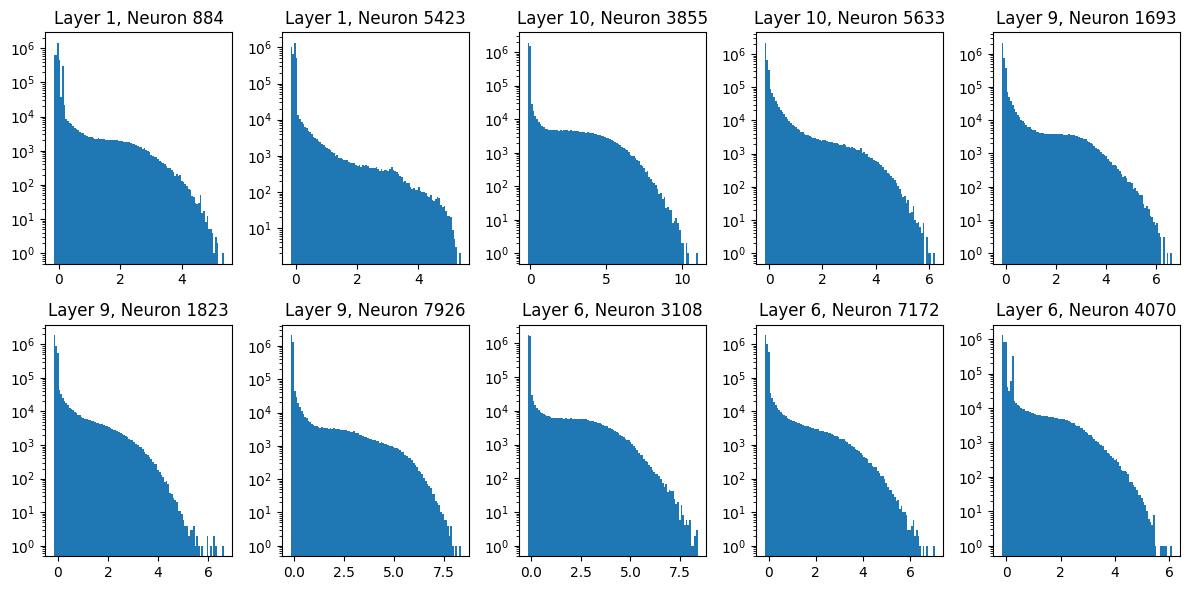

In [26]:
plot_all_neuron_histograms(act_subset_dict, logx=True)

In [83]:
def plot_all_neuron_histograms_by_class(act_subset_dict, activation_mask, label_dict, neuron_labels, n_cols=5, logx=False, plot_dist=False):
    n = len(act_subset_dict)
    n_rows = math.ceil(n / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows), sharey=True)
    for ix, (layer, neuron) in enumerate(act_subset_dict.keys()):
        label = label_dict[(layer, neuron)]
        activations = act_subset_dict[(layer, neuron)]
        lang = neuron_labels[(layer, neuron)]
        ax = axs[ix//n_cols, ix%n_cols]
        if plot_dist:
            # normalize to get empirical distribution
            _, bins = np.histogram(activations, bins=50)
            count_pos, _ = np.histogram(activations[label][activation_mask[label]], bins=bins)
            count_neg, _ = np.histogram(activations[~label][activation_mask[~label]], bins=bins)
            dist_pos = count_pos / count_pos.sum()
            dist_neg = count_neg / count_neg.sum()

            ax.hist(bins[:-1], bins, weights=dist_pos, label=lang, alpha=0.5)
            ax.hist(bins[:-1], bins, weights=dist_neg, label='other', alpha=0.5)
            ax.set_ylim(0, 0.1)
        else:  # plot counts
            positive_activations = activations[label][activation_mask[label]]
            negative_activations = activations[~label][activation_mask[~label]]
            ax.hist(positive_activations.numpy(), bins=100, alpha=0.5, label=lang)
            ax.hist(negative_activations.numpy(), bins=100, alpha=0.5, label='other')
        
        ax.set_title(f'Layer {layer}, Neuron {neuron}')
        ax.legend(title='tokens')
        if logx:
            ax.set_yscale('log')

        if ix % n_cols == 0:
            ax.set_ylabel('empirical distribution' if plot_dist else 'count')
        if ix >= (n_rows - 1) * n_cols:
            ax.set_xlabel('activation')
            
    plt.tight_layout()


In [138]:
def plot_seq_mean_vs_max_activation(act_subset_dict, activation_mask, label_dict, neuron_labels, n_cols=5):
    n = len(act_subset_dict)
    n_rows = math.ceil(n / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
    for ix, (layer, neuron) in enumerate(act_subset_dict.keys()):
        label = label_dict[(layer, neuron)]
        activations = act_subset_dict[(layer, neuron)]
        lang = neuron_labels[(layer, neuron)]
        ax = axs[ix//n_cols, ix%n_cols]
        # TODO: fix with [activation_mask[label]]
        ax.scatter(activations[label].numpy().mean(axis=1),
                   activations[label].numpy().max(axis=1),
                   label=lang, alpha=0.2, s=2, zorder=2)
        ax.scatter(activations[~label].numpy().mean(axis=1),
                   activations[~label].numpy().max(axis=1),
                   label='other', alpha=0.1, s=2)
        
        ax.set_title(f'Layer {layer}, Neuron {neuron}')
        ax.legend(title='sequence')

        if ix >= (n_rows - 1) * n_cols:
            ax.set_xlabel('mean activation')

        if ix % n_cols == 0:
            ax.set_ylabel('max activation')
            
    plt.tight_layout()


In [84]:
interp_neurons = rdf.query('k==1 and model_size=="800m"').sort_values('test_pr_auc', ascending=False).head(10).reset_index()[['feature', 'layer', 'support']].values
neuron_labels = {(l, n[0]): f for f, l, n in interp_neurons}
lang_arr = np.array(feature_dataset['lang'])
label_dict = {k: lang_arr == v for k, v in neuron_labels.items()}
activation_mask = feature_dataset['tokens'] > 1

Text(0.5, 1.02, 'pythia-800m interpretable code neurons')

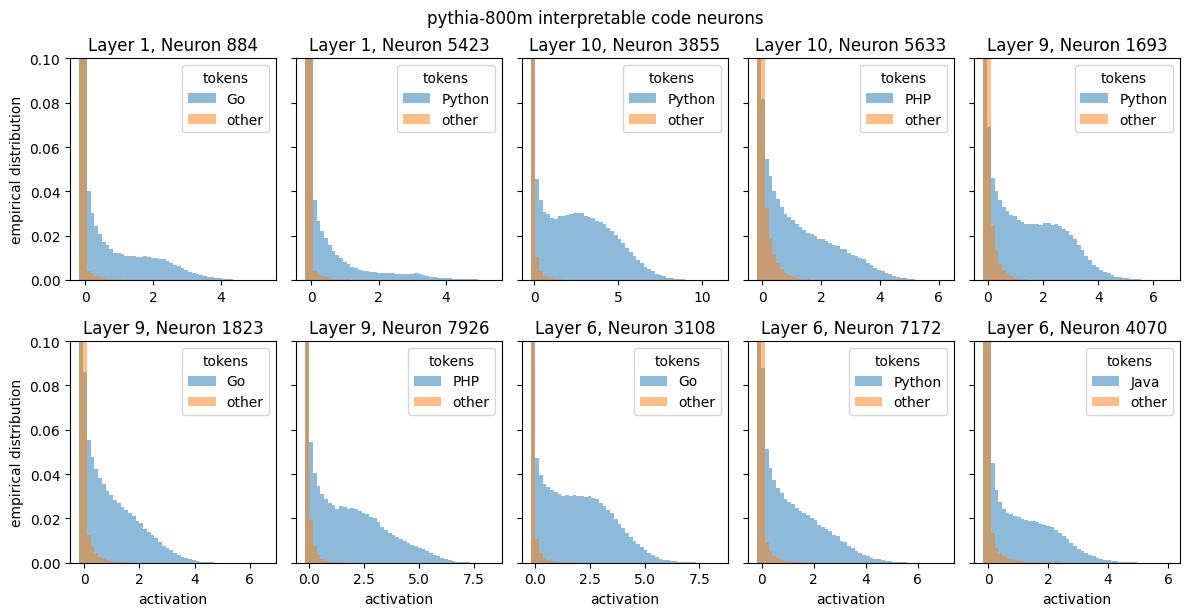

In [87]:
plot_all_neuron_histograms_by_class(act_subset_dict, activation_mask, label_dict, neuron_labels, plot_dist=True)
plt.suptitle('pythia-800m interpretable code neurons', y=1.02)

Text(0.5, 1.02, 'pythia-800m interpretable code neurons')

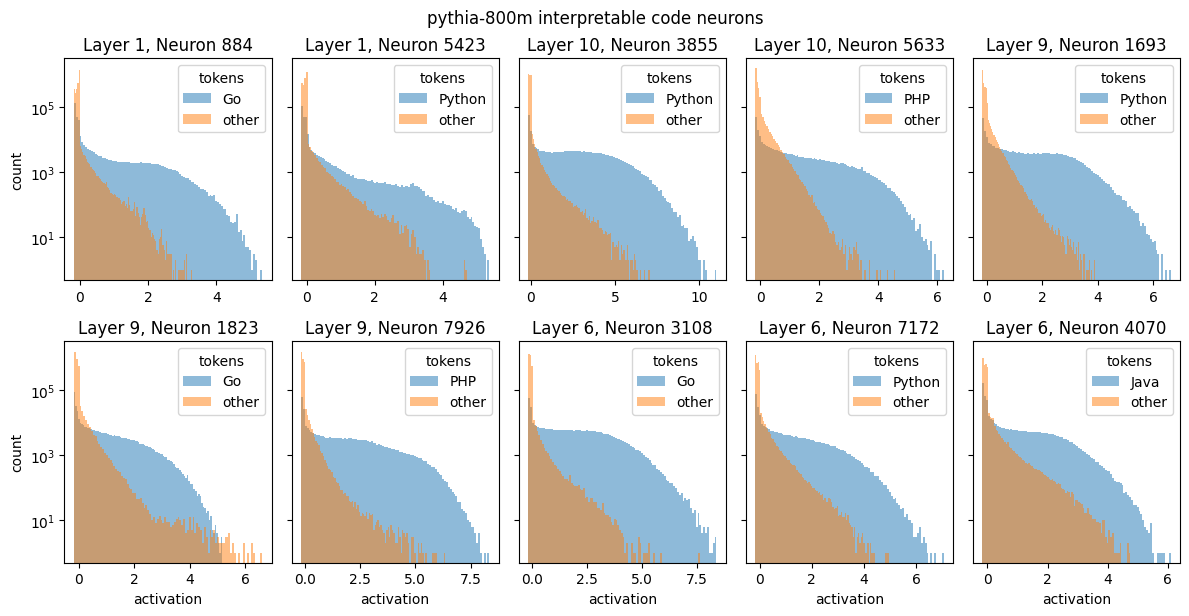

In [168]:
plot_all_neuron_histograms_by_class(act_subset_dict, activation_mask, label_dict, neuron_labels, logx=True)
plt.suptitle('pythia-800m interpretable code neurons', y=1.02)

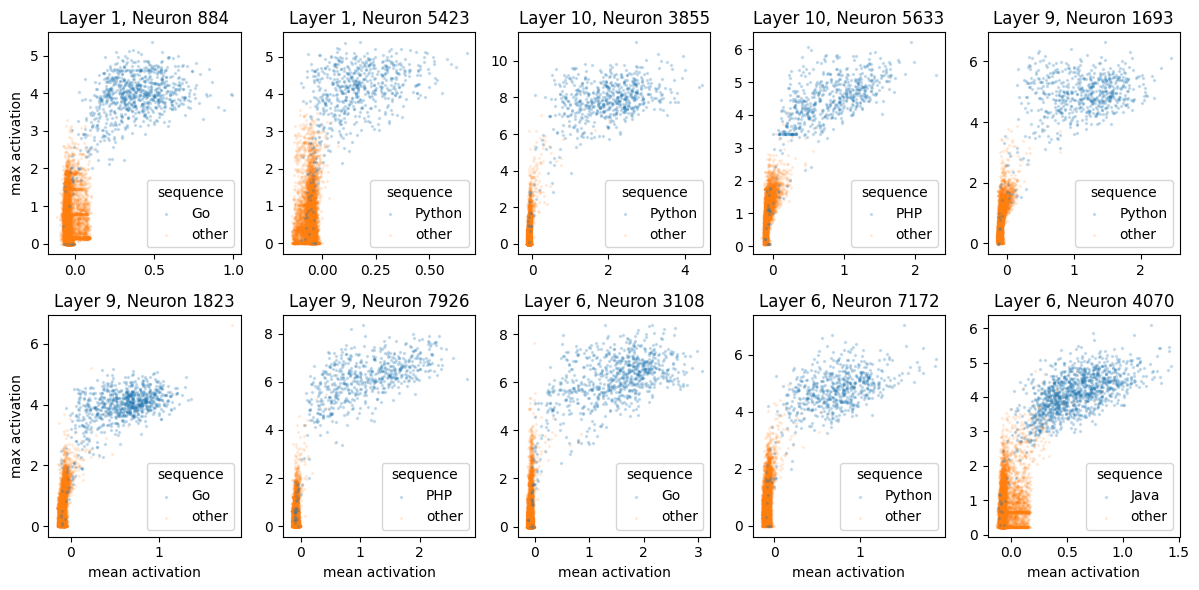

In [139]:
plot_seq_mean_vs_max_activation(act_subset_dict, activation_mask, label_dict, neuron_labels)

In [169]:
# get activation statistics for each token in the vocabulary
def activation_vocab_df(tokens, act_subset_dict, label_dict, layer, neuron):
    activations = act_subset_dict[(layer, neuron)]
    n, ctx_len = activations.shape
    token_labels = np.repeat(label_dict[(layer, neuron)][:, None], ctx_len, axis=1)

    activation_df = pd.DataFrame({
        'token': tokens.flatten(), 
        'activation': activations.flatten(),
        'label': token_labels.flatten()
    })
    vocab_df = activation_df.groupby(['token', 'label']).describe()['activation'].unstack('label')
    vocab_df = vocab_df.swaplevel(0, 1, axis=1)#.sort_index(axis=1)
    strs = list(map(lambda x: model.tokenizer.decode(x), vocab_df.index.get_level_values('token').values))
    vocab_df['strs'] = strs
    return activation_df, vocab_df


In [170]:
python_neurons = [k for k, v in neuron_labels.items() if v == 'Python']
tokens = feature_dataset['tokens']
python_vocab_dfs = {}
for layer, neuron in python_neurons:
    python_vocab_dfs[(layer, neuron)] = activation_vocab_df(tokens, act_subset_dict, label_dict, layer, neuron)


In [181]:
python_vocab_dfs[(10, 3855)][1]

label     False     True     False      True     False      True     False  \
          count    count      mean      mean       std       std       min   
token                                                                        
0      312180.0  28063.0 -0.155477 -0.155428  0.001019  0.001201 -0.156876   
1        6558.0    633.0 -0.149853 -0.149853  0.000000  0.000000 -0.149853   
2         439.0     56.0 -0.053337  0.093413  0.122910  0.765750 -0.169971   
3       20032.0   1412.0 -0.054459  1.752852  0.182523  2.156226 -0.169971   
4        9008.0   2275.0 -0.062410  0.441832  0.087962  0.862770 -0.169971   
...         ...      ...       ...       ...       ...       ...       ...   
50272    9612.0    476.0 -0.033068  1.977245  0.165436  1.910619 -0.169971   
50273    7770.0    109.0 -0.059750  1.922764  0.093273  2.017243 -0.169971   
50274   39322.0   6043.0 -0.027937  3.980720  0.127294  2.095330 -0.169971   
50275    4564.0    287.0 -0.060743  1.259563  0.080178  1.786091 -0.169971   
50276   22813.0   1040.0 -0.037621  2.338518  0.100446  2.312286 -0.169971   

label      True     False      True     False      True     False      True  \
            min       25%       25%       50%       50%       75%       75%   
token                                                                         
0     -0.156812 -0.156126 -0.156132 -0.155925 -0.155926 -0.155235 -0.155237   
1     -0.149853 -0.149853 -0.149853 -0.149853 -0.149853 -0.149853 -0.149853   
2     -0.169969 -0.107345 -0.146316 -0.049997 -0.118518 -0.010647 -0.014153   
3     -0.169970 -0.135659 -0.112963 -0.064786  0.559437 -0.013656  3.603135   
4     -0.169971 -0.121790 -0.134733 -0.055070 -0.004707 -0.010885  0.743430   
...         ...       ...       ...       ...       ...       ...       ...   
50272 -0.169931 -0.102605  0.070529 -0.034297  1.608341 -0.004943  3.529644   
50273 -0.169971 -0.114623 -0.105228 -0.055930  1.754112 -0.013153  3.604485   
50274 -0.169970 -0.054475  2.673096 -0.009873  4.100606 -0.000896  5.441165   
50275 -0.169971 -0.114710 -0.126398 -0.050435  0.256938 -0.010600  2.569789   
50276 -0.169970 -0.075903 -0.038176 -0.017732  2.004993 -0.001732  4.487717   

label     False       True           strs  
            max        max                 
token                                      
0     -0.149661  -0.147403  <|endoftext|>  
1     -0.149853  -0.149853    <|padding|>  
2      2.039814   3.517262              !  
3      4.156589   8.301641              "  
4      2.328777   5.648410              #  
...         ...        ...            ...  
50272  3.673473   8.612124                 
50273  1.917191   6.815372                 
50274  6.023285  10.269408                 
50275  1.284454   7.088635                 
50276  2.628825   7.923019                 

[28229 rows x 17 columns]

In [171]:
go_neurons = [k for k, v in neuron_labels.items() if v == 'Go']
tokens = feature_dataset['tokens']
go_vocab_dfs = {}
for layer, neuron in go_neurons:
    go_vocab_dfs[(layer, neuron)] = activation_vocab_df(tokens, act_subset_dict, label_dict, layer, neuron)


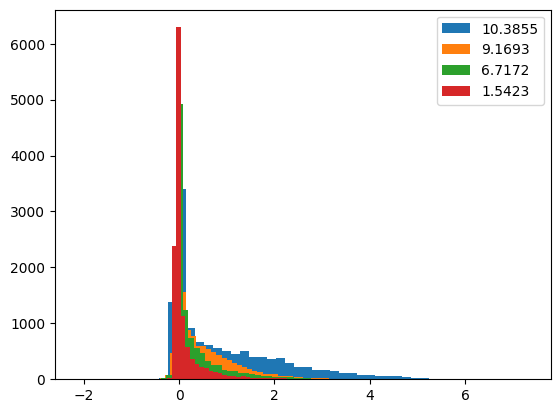

In [115]:
for ix, (l, n) in enumerate(python_neurons):
    df = python_vocab_dfs[(l, n)].unstack('label')
    plt.hist(df['mean', True] - df['mean', False], bins=50, label=f'{l}.{n}')
plt.legend()
    


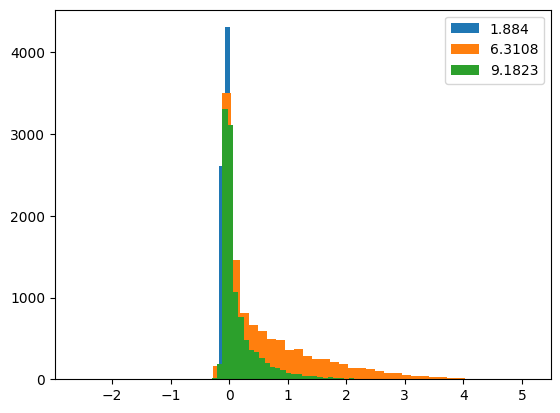

In [117]:
for ix, (l, n) in enumerate(go_neurons):
    df = go_vocab_dfs[(l, n)].unstack('label')
    plt.hist(df['mean', True] - df['mean', False], bins=50, label=f'{l}.{n}')
plt.legend()
    


In [193]:
def plot_token_activation_hists(token_df, activation_df, lang):
    plot_tokens = token_df.index.values
    fig, axs = plt.subplots(3, 5, figsize=(15, 10))
    for ix, t in enumerate(plot_tokens):
        ax = axs[ix // 5, ix % 5]
        token_activation_df = activation_df.query('token==@t')
        t_activations = token_activation_df.activation.values
        t_labels = token_activation_df.label.values

        _, bins = np.histogram(t_activations, bins=20)
        count_pos, _ = np.histogram(t_activations[t_labels], bins=bins)
        count_neg, _ = np.histogram(t_activations[~t_labels], bins=bins)
        dist_pos = count_pos / count_pos.sum()
        dist_neg = count_neg / count_neg.sum()
        ax.hist(bins[:-1], bins, weights=dist_pos, label=lang, alpha=0.5)
        ax.hist(bins[:-1], bins, weights=dist_neg, label='not', alpha=0.5)
        ax.legend(title='language')
        ax.set_title(f'activation of "{token_df.strs[t]}"')
    plt.tight_layout()


In [322]:
layer

1

In [321]:
most_dif[[(True, 'mean'), ('strs', '')]]

label      True    strs
           mean        
token                  
8102   3.455483    dict
4064   3.891778    from
5858   3.150602    pass
5653   3.605254   False
2491   2.701184   range
5088   3.530105    True
1286   3.010657    self
1542   2.752033     for
7684   3.559317      os
8472   2.694386     len
3845   2.327313   print
1881   2.995531    self
8168   2.044378      []
3113   2.207475    with
1545   1.960315     def

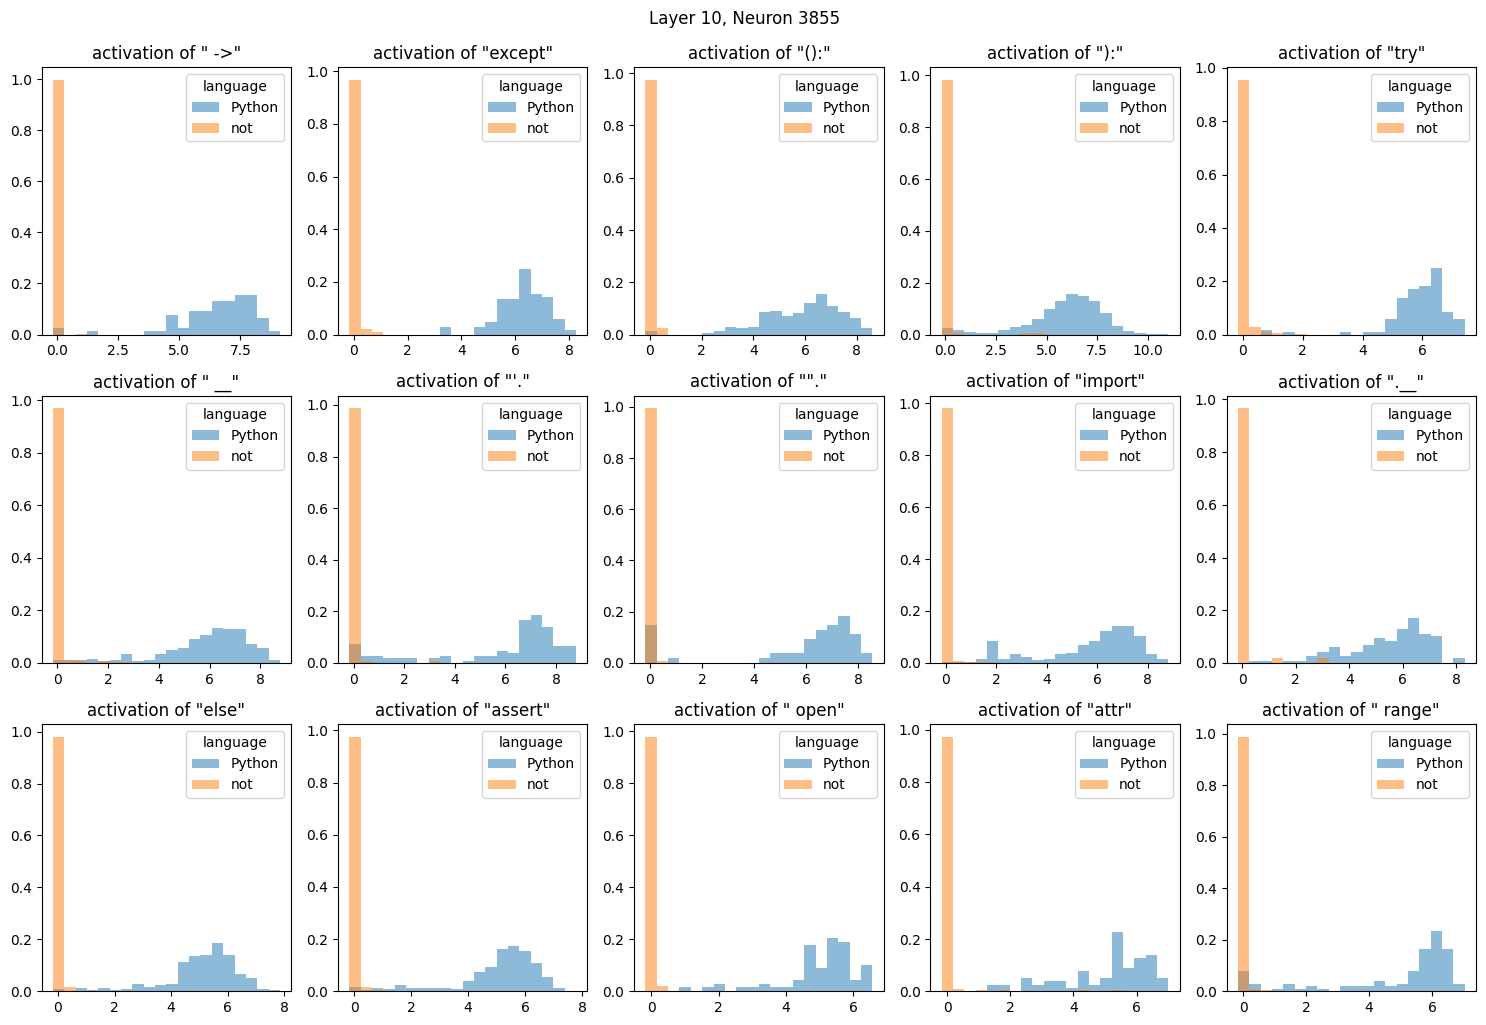

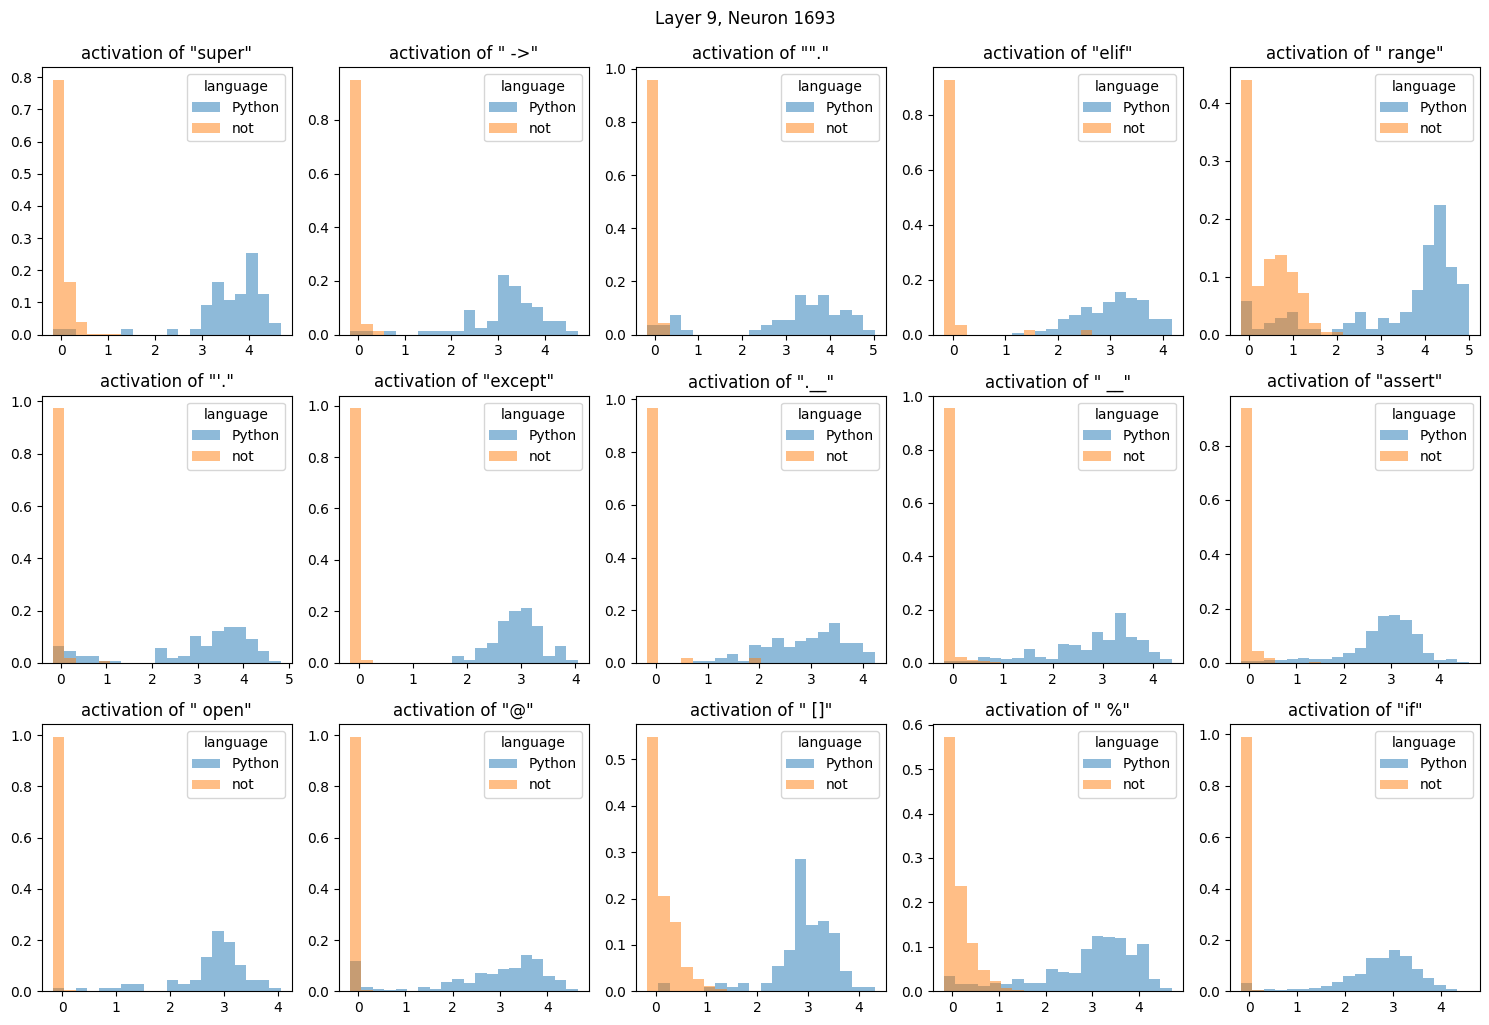

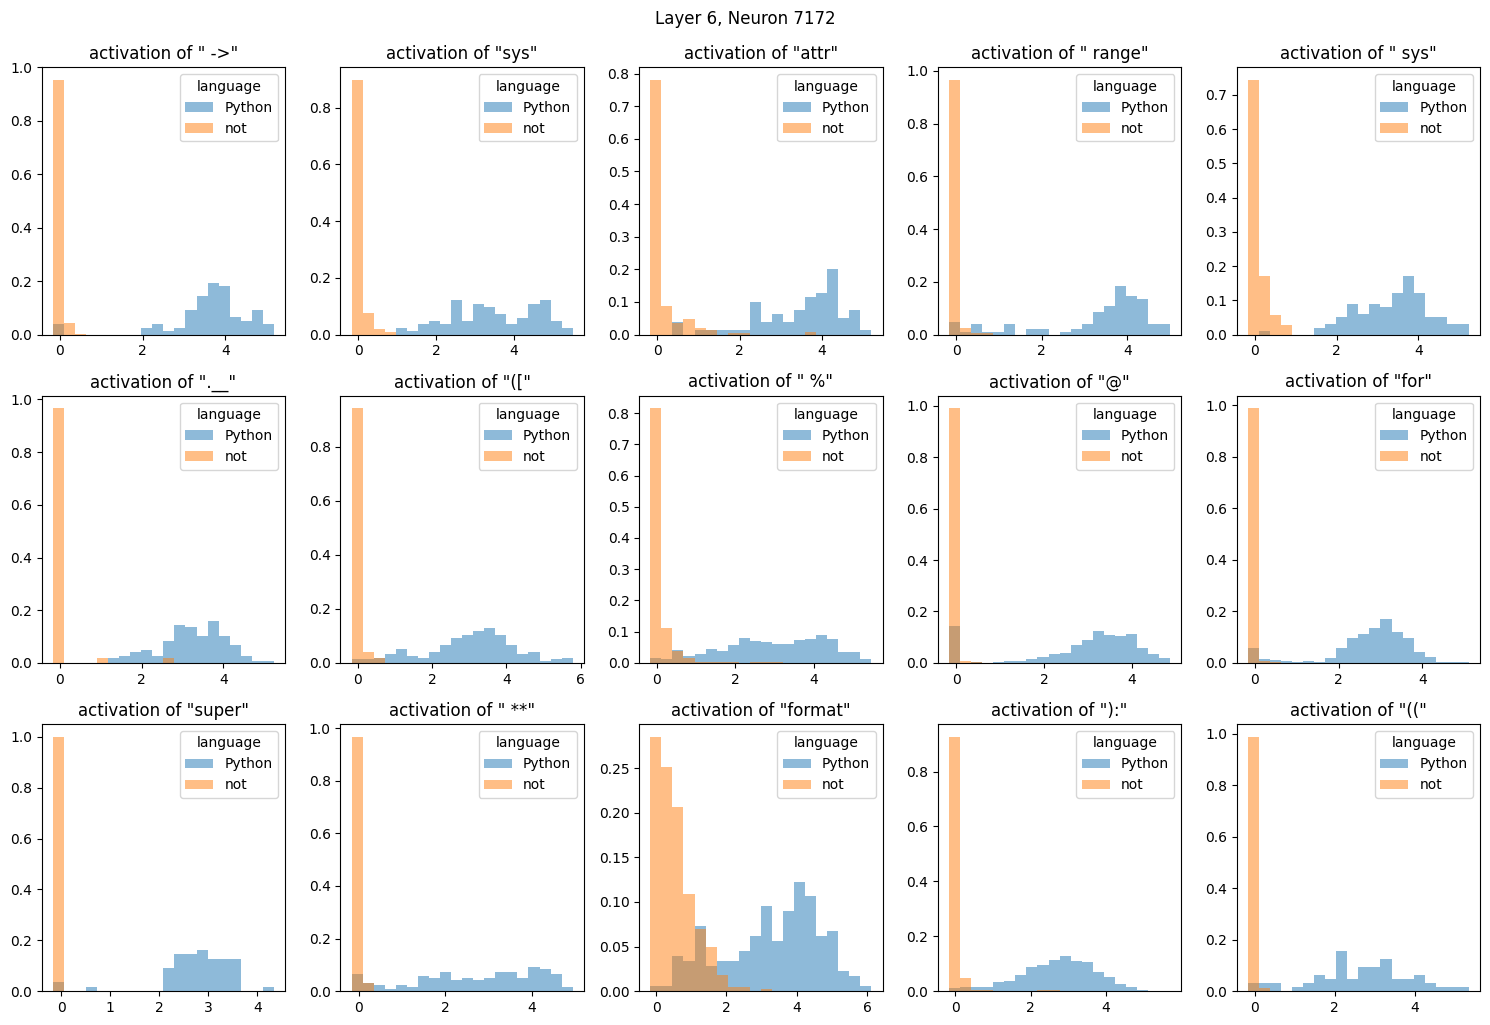

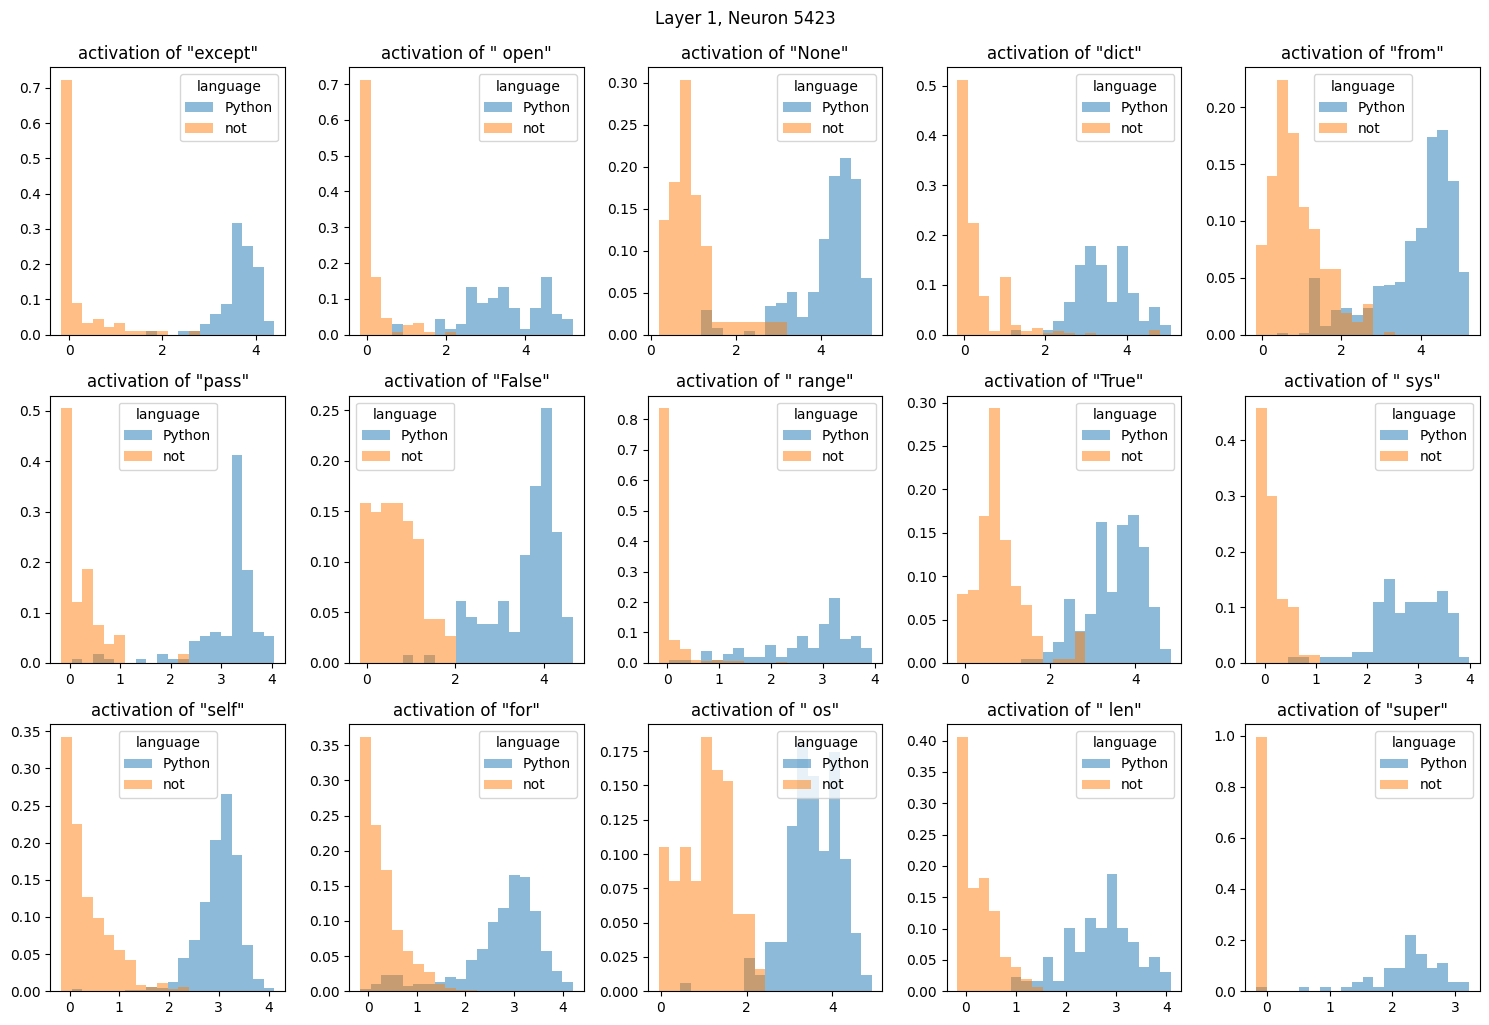

In [335]:
freq_threshold = 50
for (layer, neuron), (activation_df, vocab_df) in python_vocab_dfs.items():
    common_df = vocab_df.loc[(vocab_df[True, 'count'] > freq_threshold) & (vocab_df[False, 'count'] > freq_threshold)]
    most_dif = common_df.loc[
        (common_df[True, 'mean'] - common_df[False, 'mean']).sort_values(ascending=False).index
    ].head(15)

    plot_token_activation_hists(most_dif, activation_df, 'Python')
    plt.suptitle(f'Layer {layer}, Neuron {neuron}', y=1.02)
    plt.show()

In [336]:
vocab_averages = {}
for (layer, neuron), (activation_df, vocab_df) in python_vocab_dfs.items():
    vocab_average = vocab_df[[(True, 'mean'), (False, 'mean')]].values
    vocab_averages[(True, f'{layer}.{neuron}')] = vocab_average[:, 0]
    vocab_averages[(False, f'{layer}.{neuron}')] = vocab_average[:, 1]
vocab_averages[('token', '')] = vocab_df.index.values
vocab_averages[('string', '')] = vocab_df.strs.values
vocab_averages[(True, 'counts')] = vocab_df[True, 'count'].values
vocab_averages[(False, 'counts')] = vocab_df[False, 'count'].values
neuron_vocab_df = pd.DataFrame(vocab_averages).sort_index(axis=1)
neuron_vocab_df = neuron_vocab_df.set_index('token')

In [347]:
common_true = (neuron_vocab_df[(True, 'counts')] > 100).values
common_false = (neuron_vocab_df[(False, 'counts')] > 100).values

common_positive_mean = neuron_vocab_df.loc[common_true][True].drop('counts', axis=1)#.sort_values('mean', ascending=False).head(20)
common_negative_mean = neuron_vocab_df.loc[common_false][False].drop('counts', axis=1)#.sort_values('mean', ascending=False).head(20)

In [348]:
common_positive_mean.corr().sort_index()

1.5423   10.3855    6.7172    9.1693
1.5423   1.000000  0.384843  0.403631  0.281191
10.3855  0.384843  1.000000  0.788676  0.894884
6.7172   0.403631  0.788676  1.000000  0.779961
9.1693   0.281191  0.894884  0.779961  1.000000

Text(0, 0.5, 'Python average activation')

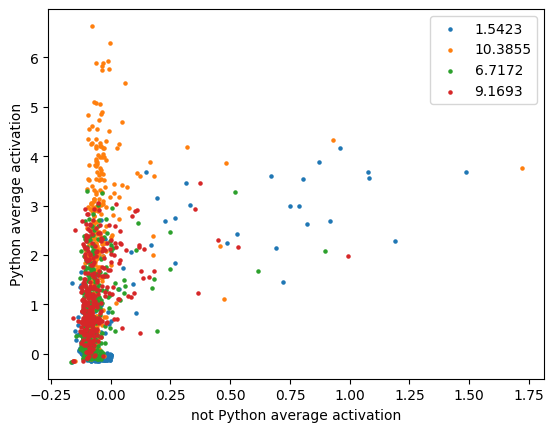

In [349]:
for n in common_positive_mean.columns:
    plt.scatter(neuron_vocab_df.loc[common_true][(False, n)],
                neuron_vocab_df.loc[common_true][(True, n)], label=n, s=5)
plt.legend()
plt.xlabel('not Python average activation')
plt.ylabel('Python average activation')

In [350]:
top_k = 20
neuron_positive_strs = {}
neuron_negative_strs = {}
for n in common_positive_mean.columns:
    common_true_strings = neuron_vocab_df.loc[common_true]['string'].values
    common_false_strings = neuron_vocab_df.loc[common_false]['string'].values
    
    most_positive = np.argsort(neuron_vocab_df.loc[common_true][(True, n)].values)[-top_k:][::-1]
    most_negative = np.argsort(neuron_vocab_df.loc[common_false][(False, n)].values)[-top_k:][::-1]
    
    neuron_positive_strs[n] = common_true_strings[most_positive]
    neuron_negative_strs[n] = common_false_strings[most_negative]

positive_str_df = pd.DataFrame(neuron_positive_strs).sort_index(axis=1, key=lambda x: [float(n) for n in x])
negative_str_df = pd.DataFrame(neuron_negative_strs).sort_index(axis=1, key=lambda x: [float(n) for n in x])

In [351]:
# highest average activation by token and neuron for python code
positive_str_df

1.5423  6.7172  9.1693 10.3855
0       None   range   range     __(
1       from  format    elif  except
2         np     .__     __(      ):
3       None      ([  except     ():
4     except       %      '.     try
5      False       @     len      __
6         os     for      []  import
7       True       [     .__      '.
8       dict      ):       %     .__
9       pass      **      __    else
10      self  except  assert  assert
11      self       =     ():   raise
12      True      if      if  return
13       for  return       @      if
14     range  kwargs           range
15       len  append    \n\n       =
16     False   class      ==    elif
17     shape       =  import      []
18   request      os  return   Field
19     print      __      ):    with

In [352]:
# highest average activation by token and neuron for non python code
negative_str_df

1.5423    6.7172  9.1693     10.3855
0    require    layout     Max          {%
1          Q        {%       W        ="{{
2         os        %}      =%          {{
3      split      ="{{       N          %}
4       from        {{       Z          {{
5       True   default   range      useful
6   continue    format     len        post
7       self       mod     max          ':
8         re     cache     got     product
9    request      auto     Has         url
10     False   DEFAULT     ([]       False
11       Ext   default   width          ',
12      axis       max     Mod     example
13         R       aut      %}      rights
14   request   padding     ','   copyright
15    Before        {{       O        load
16        ax     block       U          ym
17     while    strict    Sign           %
18         Q    FORMAT     ">"        CHAR
19      Back    Layout     Len      errors

## Go code

/var/folders/8f/qz9dtbzx2s77drzzcdl8xztm0000gn/T/ipykernel_64127/3438378787.py:19: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


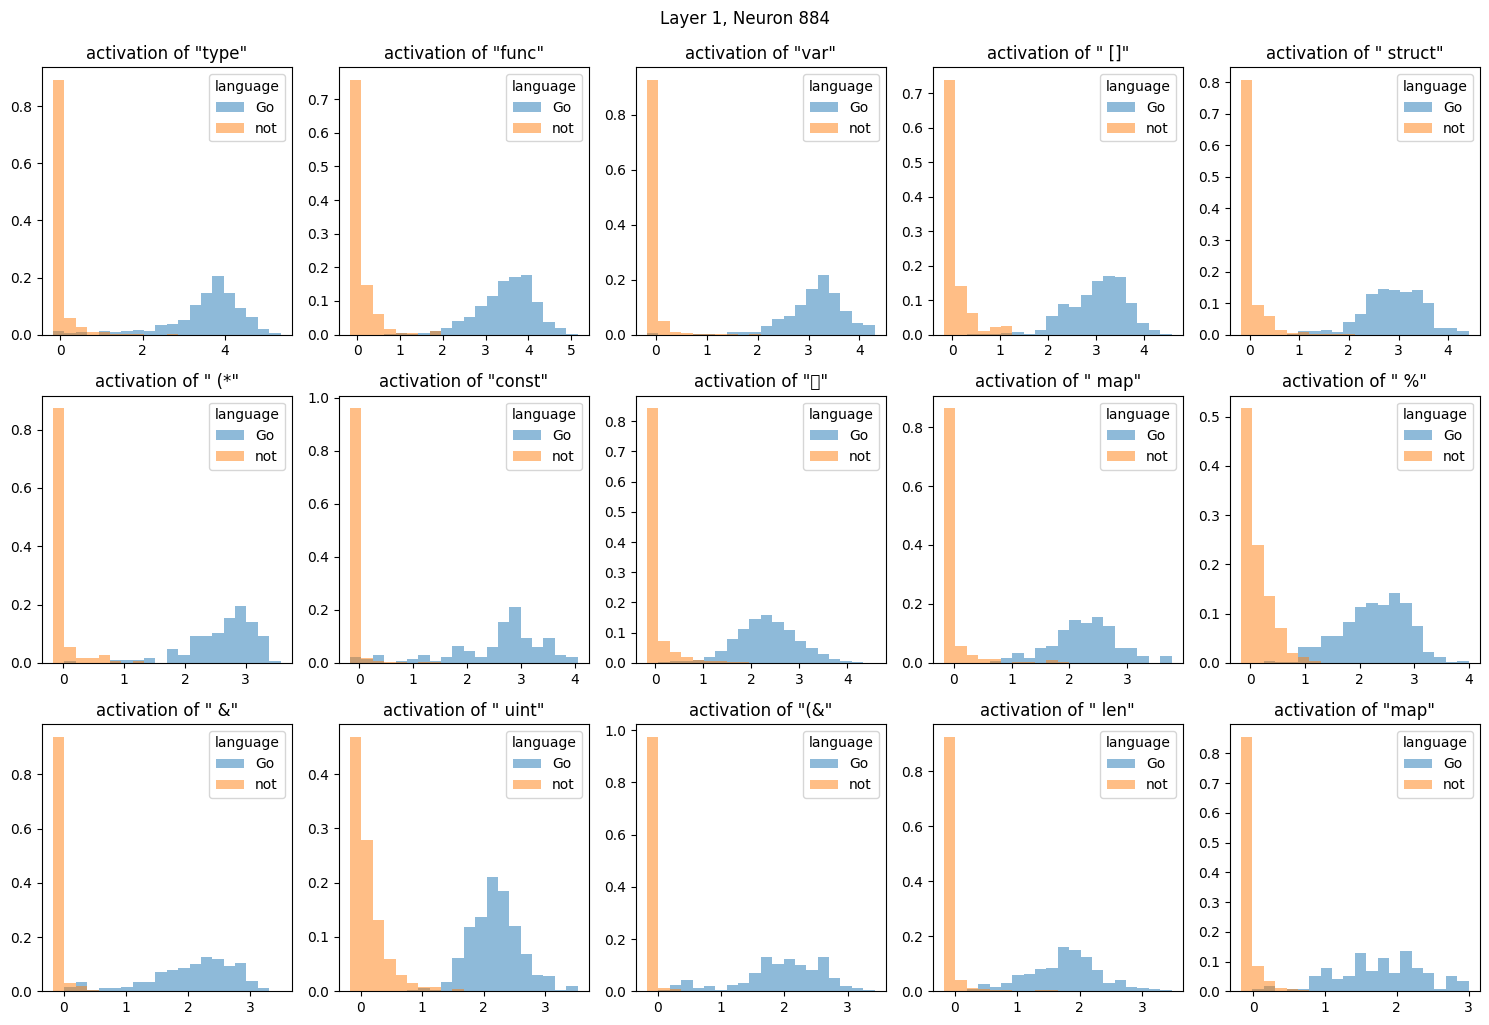

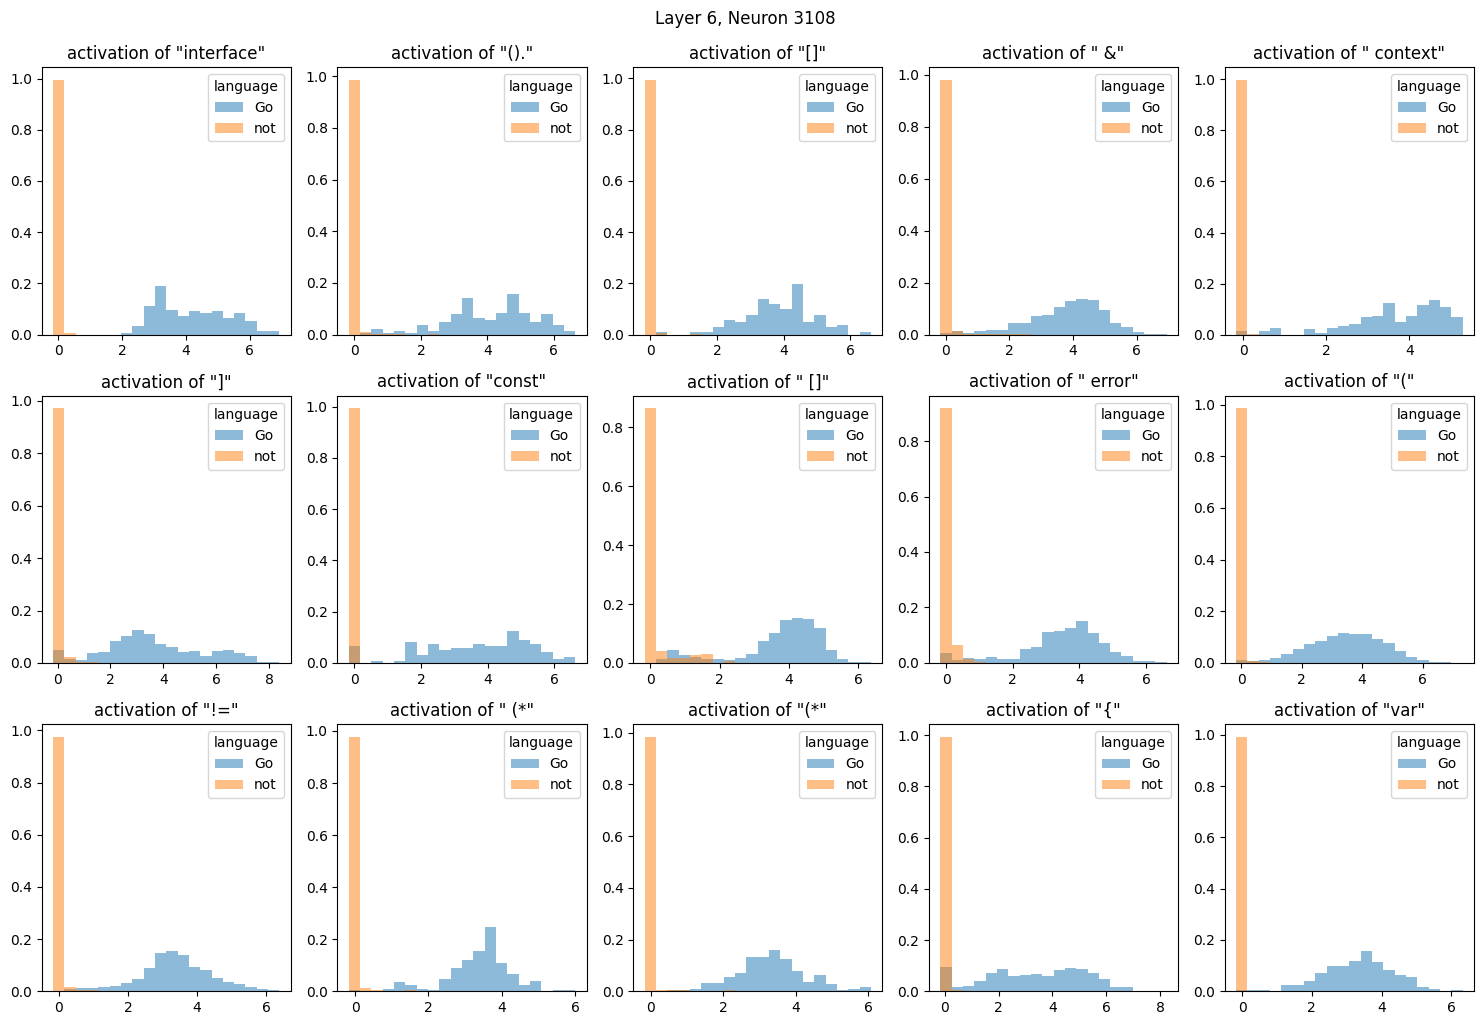

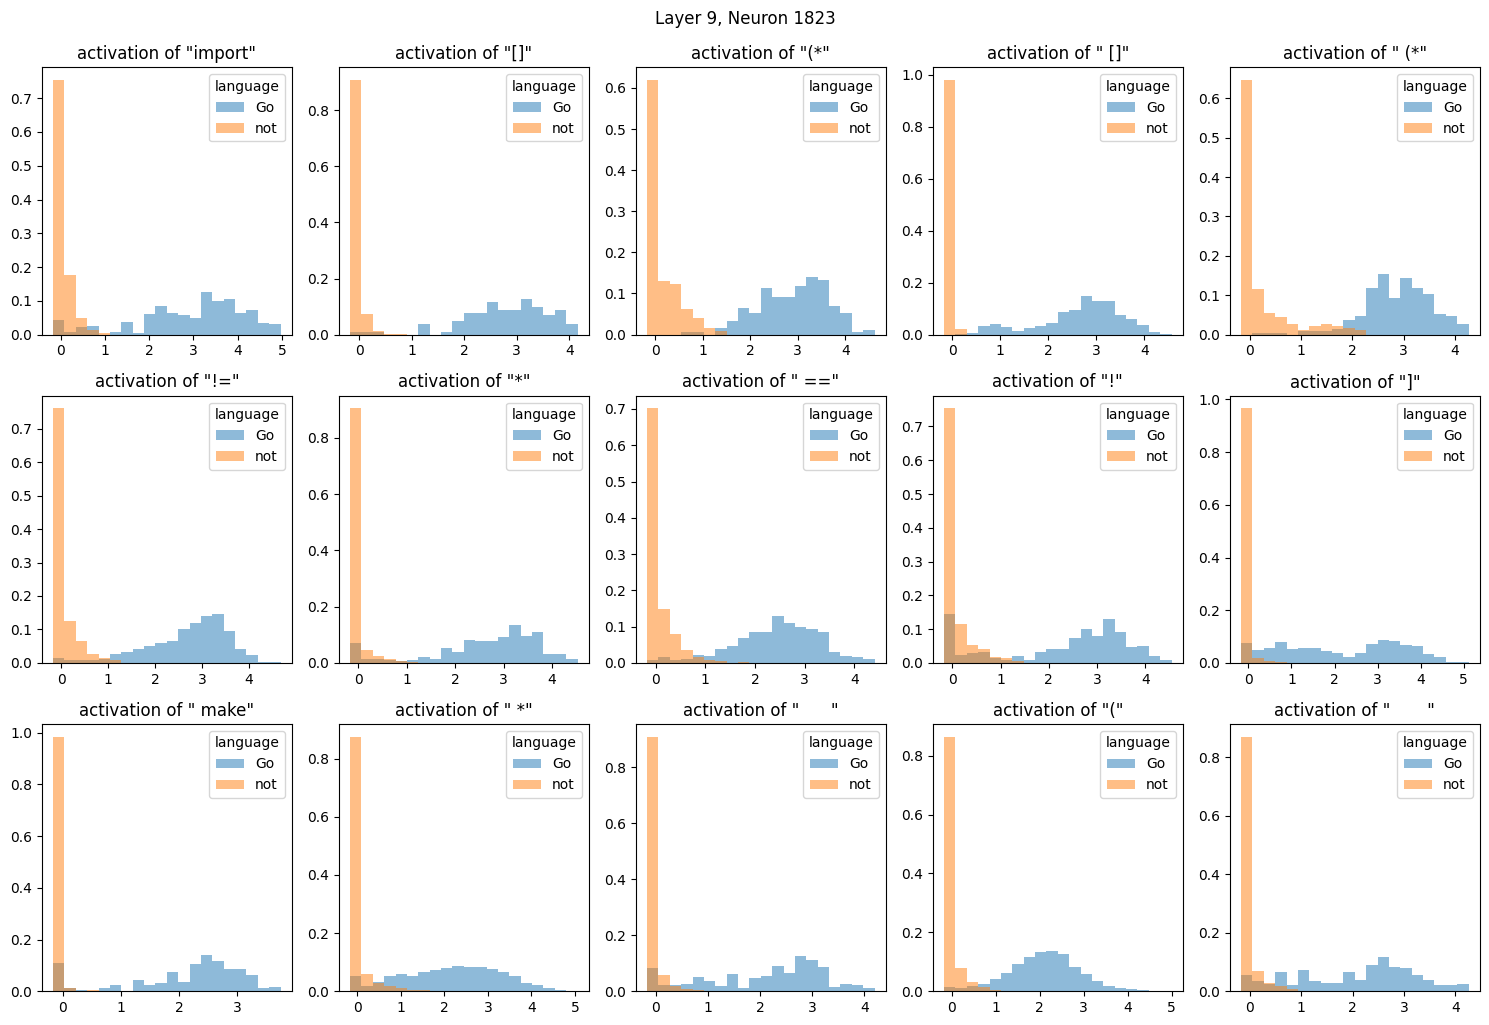

In [195]:
for (layer, neuron), (activation_df, vocab_df) in go_vocab_dfs.items():
    common_df = vocab_df.loc[(vocab_df[True, 'count'] > 100) & (vocab_df[False, 'count'] > 100)]
    most_dif = common_df.loc[
        (common_df[True, 'mean'] - common_df[False, 'mean']).sort_values(ascending=False).index
    ].head(15)

    plot_token_activation_hists(most_dif, activation_df, 'Go')
    plt.suptitle(f'Layer {layer}, Neuron {neuron}', y=1.02)
    plt.show()

In [353]:
vocab_averages = {}
for (layer, neuron), (activation_df, vocab_df) in go_vocab_dfs.items():
    vocab_average = vocab_df[[(True, 'mean'), (False, 'mean')]].values
    vocab_averages[(True, f'{layer}.{neuron}')] = vocab_average[:, 0]
    vocab_averages[(False, f'{layer}.{neuron}')] = vocab_average[:, 1]
vocab_averages[('token', '')] = vocab_df.index.values
vocab_averages[('string', '')] = vocab_df.strs.values
vocab_averages[(True, 'counts')] = vocab_df[True, 'count'].values
vocab_averages[(False, 'counts')] = vocab_df[False, 'count'].values
neuron_vocab_df = pd.DataFrame(vocab_averages).sort_index(axis=1)
neuron_vocab_df = neuron_vocab_df.set_index('token')

In [354]:
common_true = (neuron_vocab_df[(True, 'counts')] > 100).values
common_false = (neuron_vocab_df[(False, 'counts')] > 100).values

common_positive_mean = neuron_vocab_df.loc[common_true][True].drop('counts', axis=1)#.sort_values('mean', ascending=False).head(20)
common_negative_mean = neuron_vocab_df.loc[common_false][False].drop('counts', axis=1)#.sort_values('mean', ascending=False).head(20)

In [355]:
common_positive_mean.corr().sort_index()

1.884    6.3108    9.1823
1.884   1.000000  0.499605  0.443180
6.3108  0.499605  1.000000  0.711252
9.1823  0.443180  0.711252  1.000000

Text(0, 0.5, 'Go average activation')

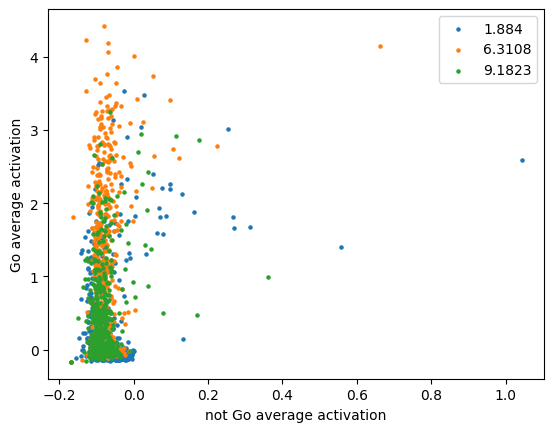

In [357]:
for n in common_positive_mean.columns:
    plt.scatter(neuron_vocab_df.loc[common_true][(False, n)],
                neuron_vocab_df.loc[common_true][(True, n)], label=n, s=5)
plt.legend()
plt.xlabel('not Go average activation')
plt.ylabel('Go average activation')

In [358]:
top_k = 20
neuron_positive_strs = {}
neuron_negative_strs = {}
for n in common_positive_mean.columns:
    common_true_strings = neuron_vocab_df.loc[common_true]['string'].values
    common_false_strings = neuron_vocab_df.loc[common_false]['string'].values
    
    most_positive = np.argsort(neuron_vocab_df.loc[common_true][(True, n)].values)[-top_k:][::-1]
    most_negative = np.argsort(neuron_vocab_df.loc[common_false][(False, n)].values)[-top_k:][::-1]
    
    neuron_positive_strs[n] = common_true_strings[most_positive]
    neuron_negative_strs[n] = common_false_strings[most_negative]

positive_str_df = pd.DataFrame(neuron_positive_strs).sort_index(axis=1, key=lambda x: [float(n) for n in x])
negative_str_df = pd.DataFrame(neuron_negative_strs).sort_index(axis=1, key=lambda x: [float(n) for n in x])

In [359]:
positive_str_df

1.884     6.3108   9.1823
0       type        ([]      ([]
1       func     append   import
2        var  interface       (*
3         []       beta       (*
4       func        ().       []
5     struct        fmt       !=
6         (*         []       []
7    package          &        *
8      const         []      {})
9         :=    context       ==
10       fmt          ]        !
11        \t      const   append
12         %        {})        *
13       map      error        ]
14       fmt          (        (
15       ([]    reflect     make
16      uint        {},         
17        ""         !=         
18   reflect         (*     case
19         &          {   return

In [360]:
negative_str_df

1.884            6.3108      9.1823
0    package                '>      inline
1      level              PECT      sizeof
2       code  \n\t\t\t\t\t\t\t      sizeof
3       Code            ../../      struct
4    Package           package           �
5    example                ow   governing
6     fields               Pro     include
7      types                yt          *,
8         ua                go     typedef
9      field                pc         OUT
10   package              EVEN           �
11        "%                Or           �
12       ("%                []         "?>
13      Code            client        DECL
14   message    \n\t\t\t\t\t\t      inline
15     items          Iterator      static
16        --               And          **
17        "/                PC      vector
18       SYS               raw          (*
19     Level                ='           �

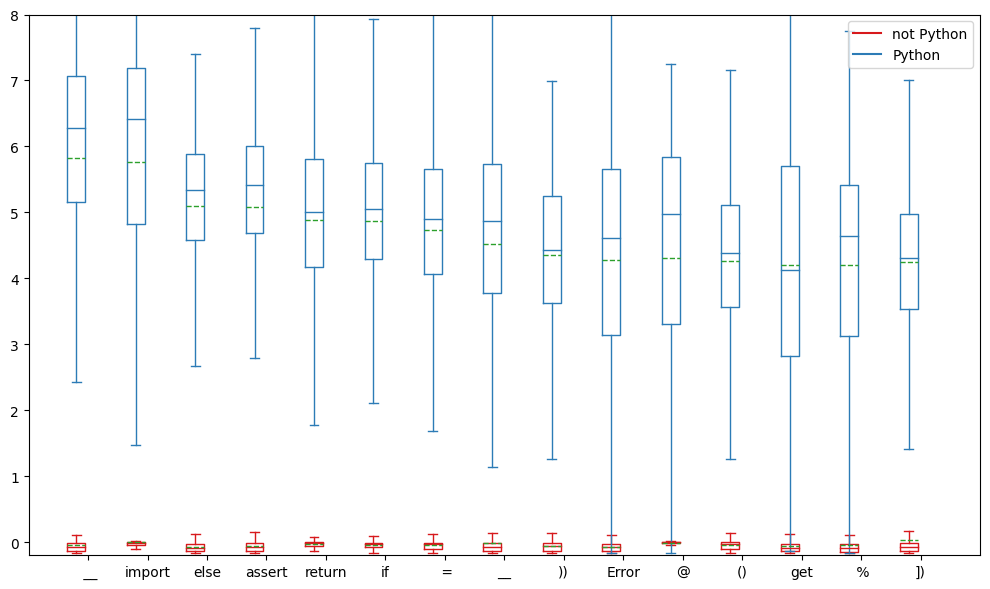

In [47]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

ticks = [model.tokenizer.decode(t) for t in most_dif_tokens]

fig, ax = plt.subplots(figsize=(10, 6))
negative_activations = [activation_df.query('label==False and token==@t').activation.values for t in most_dif_tokens]
positive_activations = [activation_df.query('label==True and token==@t').activation.values for t in most_dif_tokens]

n_tokens = len(most_dif_tokens)
positions=np.array(np.arange(n_tokens))*2.0-0.4

bpl = ax.boxplot(negative_activations, positions=positions, sym='', widths=0.6, meanline=True, showmeans=True)
bpr = ax.boxplot(positive_activations, positions=positions, sym='', widths=0.6, meanline=True, showmeans=True)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
ax.plot([], c='#D7191C', label='not Python')
ax.plot([], c='#2C7BB6', label='Python')
ax.legend(loc='upper right')

ax.set_xticks(np.arange(0, len(ticks) * 2, 2), ticks)
ax.set_xlim(-2, len(ticks)*2)
ax.set_ylim(-0.2, 8)
plt.tight_layout()

## Look at dataset examples

In [361]:
def prepare_colored_tokens_data(feature_dataset, tokenizer, act_subset_dict, neuron, lang, n=100):
    # decode tokens exactly as they appear in the raw text
    def decode_tokens(tokens):
        return [tokenizer.decode([t]) for t in tokens if t > 1]

    def non_trivial_activation_list(token_vector, activation_vector):
        return activation_vector[token_vector > 1].tolist()

    token_list = [decode_tokens(feature_dataset['tokens'][i]) 
        for i in range(n) if feature_dataset['lang'][i] == lang]

    activation_list = [
        non_trivial_activation_list(
            feature_dataset['tokens'][i], act_subset_dict[neuron][i])
        for i in range(n) if feature_dataset['lang'][i] == lang
    ]
    formatted_activation_list = [[[[t]] for t in seq] for seq in activation_list]
    return token_list, formatted_activation_list

#print(''.join(token_list[5]))

In [362]:
n=100
lang = 'Python'
neuron = (10, 3855)

token_list, activation_list = prepare_colored_tokens_data(feature_dataset, model.tokenizer, act_subset_dict, neuron, lang, n=100)

In [363]:
from circuitsvis.tokens import colored_tokens
ix=5
colored_tokens(token_list[ix], activation_list[ix])

In [364]:
n=100
lang = 'Go'
neuron = (1, 884)

token_list, activation_list = prepare_colored_tokens_data(feature_dataset, model.tokenizer, act_subset_dict, neuron, lang, n=100)

In [365]:
ix=4
colored_tokens(token_list[ix], activation_list[ix])

In [366]:
n=100
lang = 'Java'
neuron = (6, 4070)

token_list, activation_list = prepare_colored_tokens_data(feature_dataset, model.tokenizer, act_subset_dict, neuron, lang, n=100)

In [367]:
ix=3
colored_tokens(token_list[ix], activation_list[ix])

In [ ]:
# ignore 

n_layers = rdf.reset_index().groupby('model_size').layer.max().to_dict()

one_sp = rdf.query('k==1').sort_values('test_pr_auc', ascending=False).head(10)
# plot one_sp for each feature:
# x axis: normalized layer depth
# y axis: test_pr_auc
# color: model size
def plot_model_k_sparse_performance_by_feature_and_depth(rdf, k, metric):
    features = rdf.index.get_level_values('feature').unique()
    fig, axs = plt.subplots(math.ceil(len(features) / 3), 3, figsize=(15, 10), sharey=True)
    for ix, f in enumerate(features):
        ax = axs[ix // 3, ix % 3]
        for s in sizes:
            line = rdf.loc[s, f, :, k][metric]
            y = line.values
            x = line.index / n_layers[s]
            ax.plot(x, y, label=s)
        
        ax.set_title(f)
        ax.set_xlabel('Normalized layer depth')
        ax.set_ylabel(metric)
    ax.legend()
    plt.tight_layout()
    plt.suptitle(f'Best {k}-sparse performance by feature and depth', y=1.02)

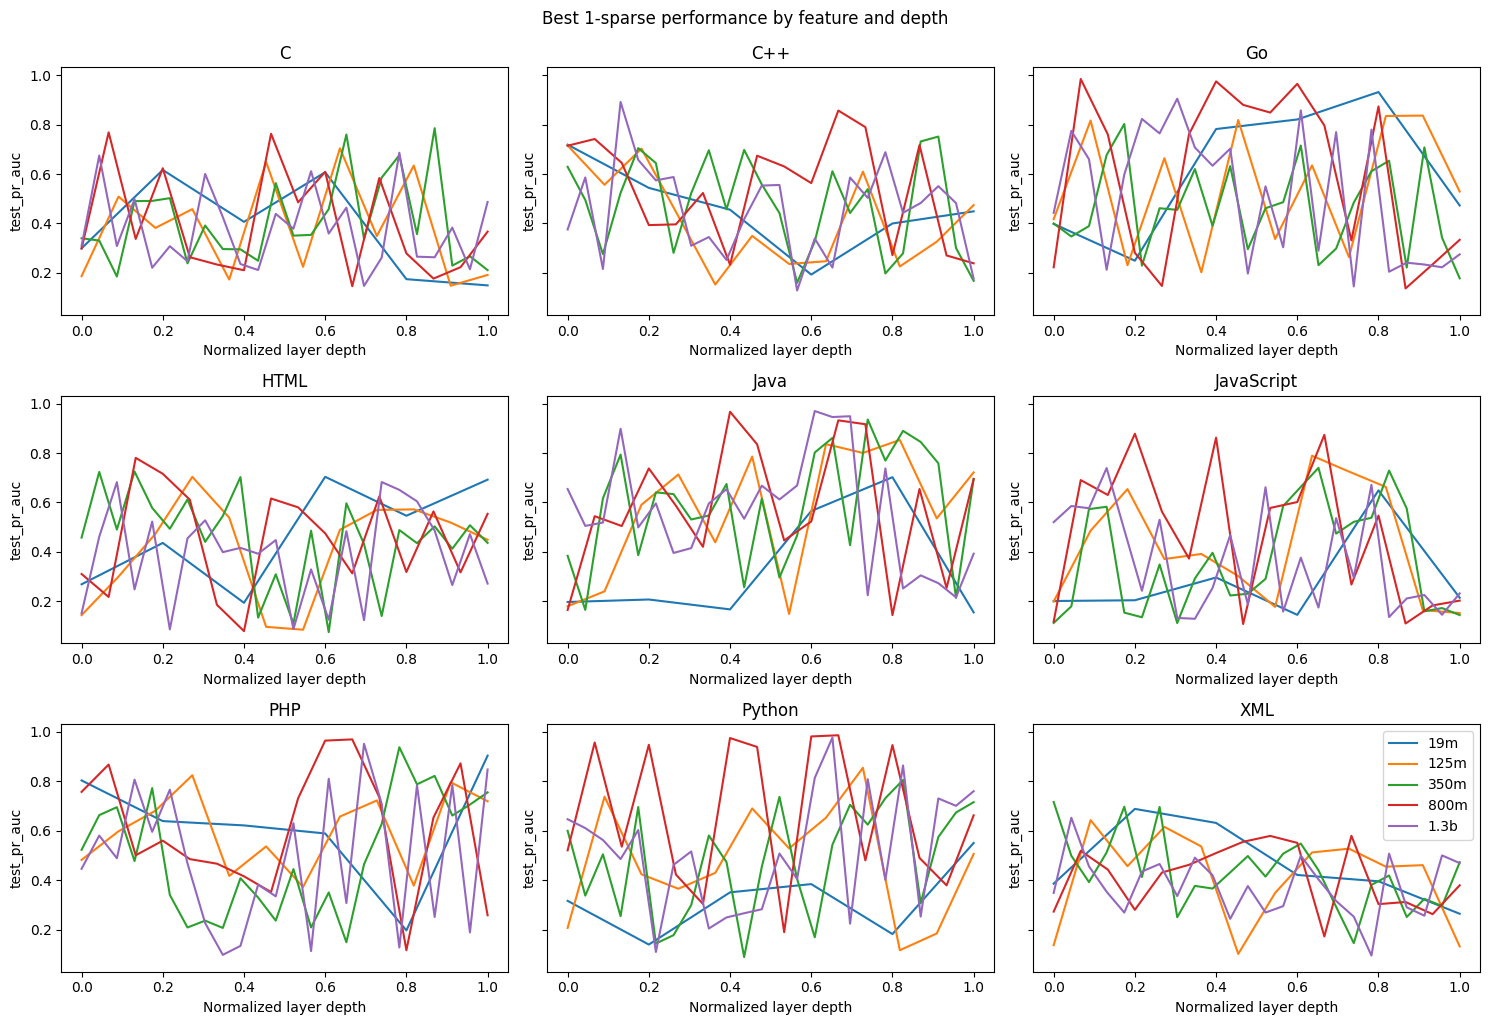

In [ ]:
plot_model_k_sparse_performance_by_feature_and_depth(rdf, 1, 'test_pr_auc')

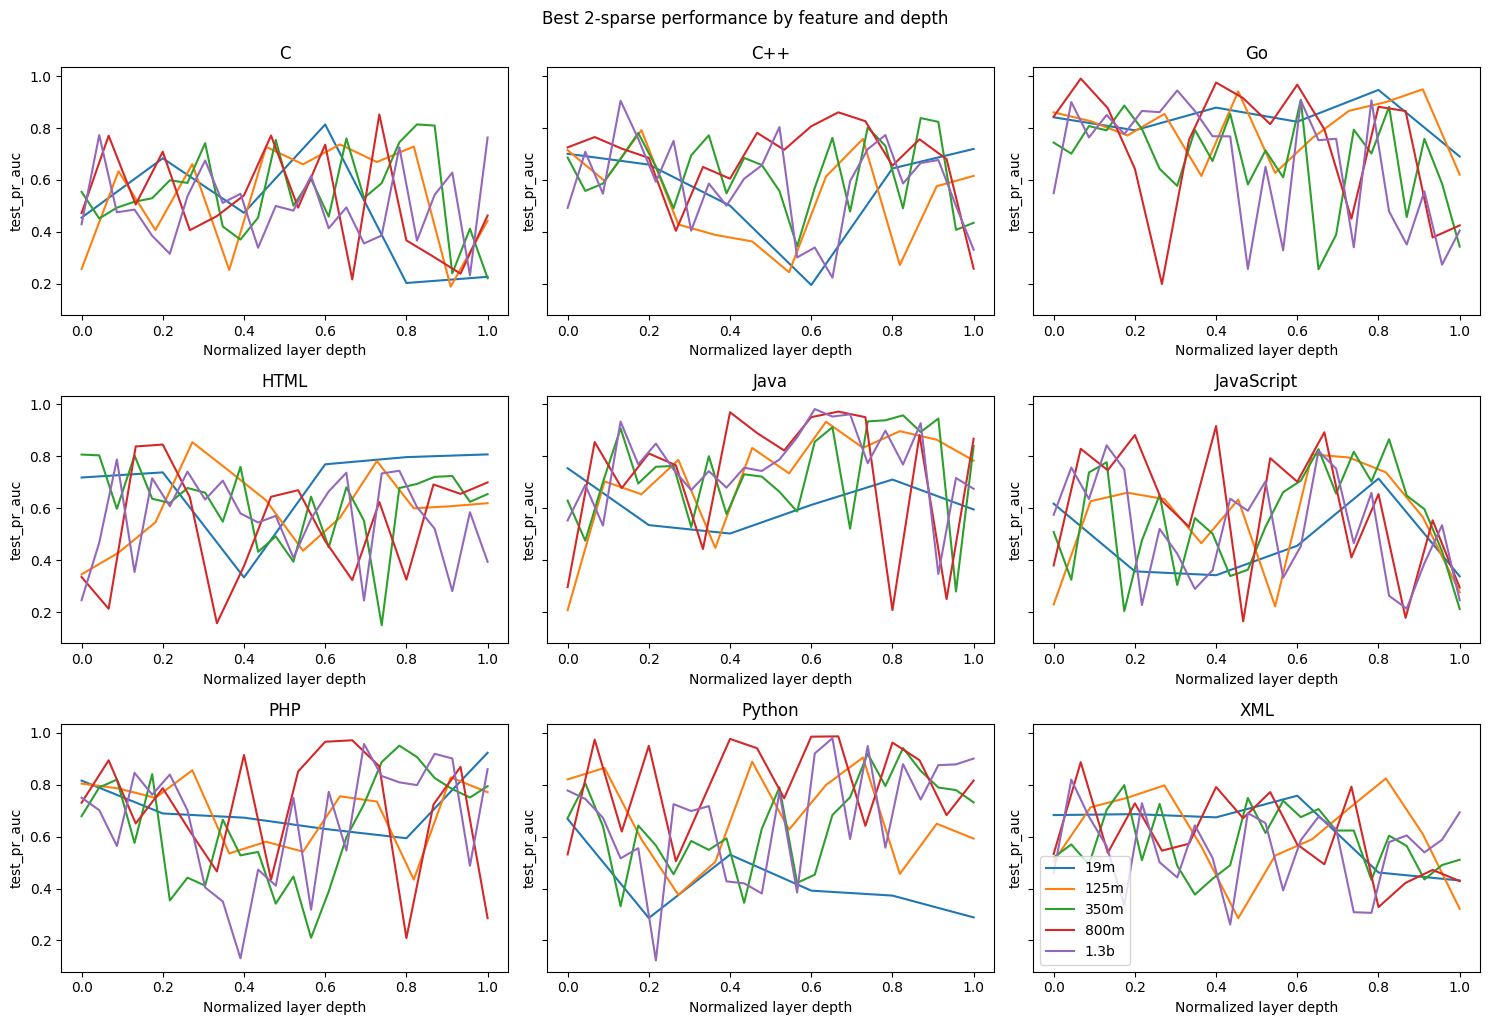

In [ ]:
plot_model_k_sparse_performance_by_feature_and_depth(rdf, 2, 'test_pr_auc')